Make a copy of the colab. Rename the colab as follows:

```
PA-2_<roll-number>.ipynb
```

We will be running your colab. It should produce the graphs/charts as explaind in the problem statements. Add comments wherever necessary. At the end of each problem configuration, enter your observations in the text cell. This should include your analysis of the learning curves obtaind.

### Libraries

Stick to `NumPy` and a library such as `matplotlib`, `seaborn` or `plotly` for rendering plots.

In [ ]:
# import necessary libraries here
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sc

## Environment description

This exercise aims to familiarize you with two popular Temporal Difference Learning algorithms: **SARSA** and **Q-Learning**. You will solve several variants of the Grid World problem (a sample world is shown below in Figure 1).

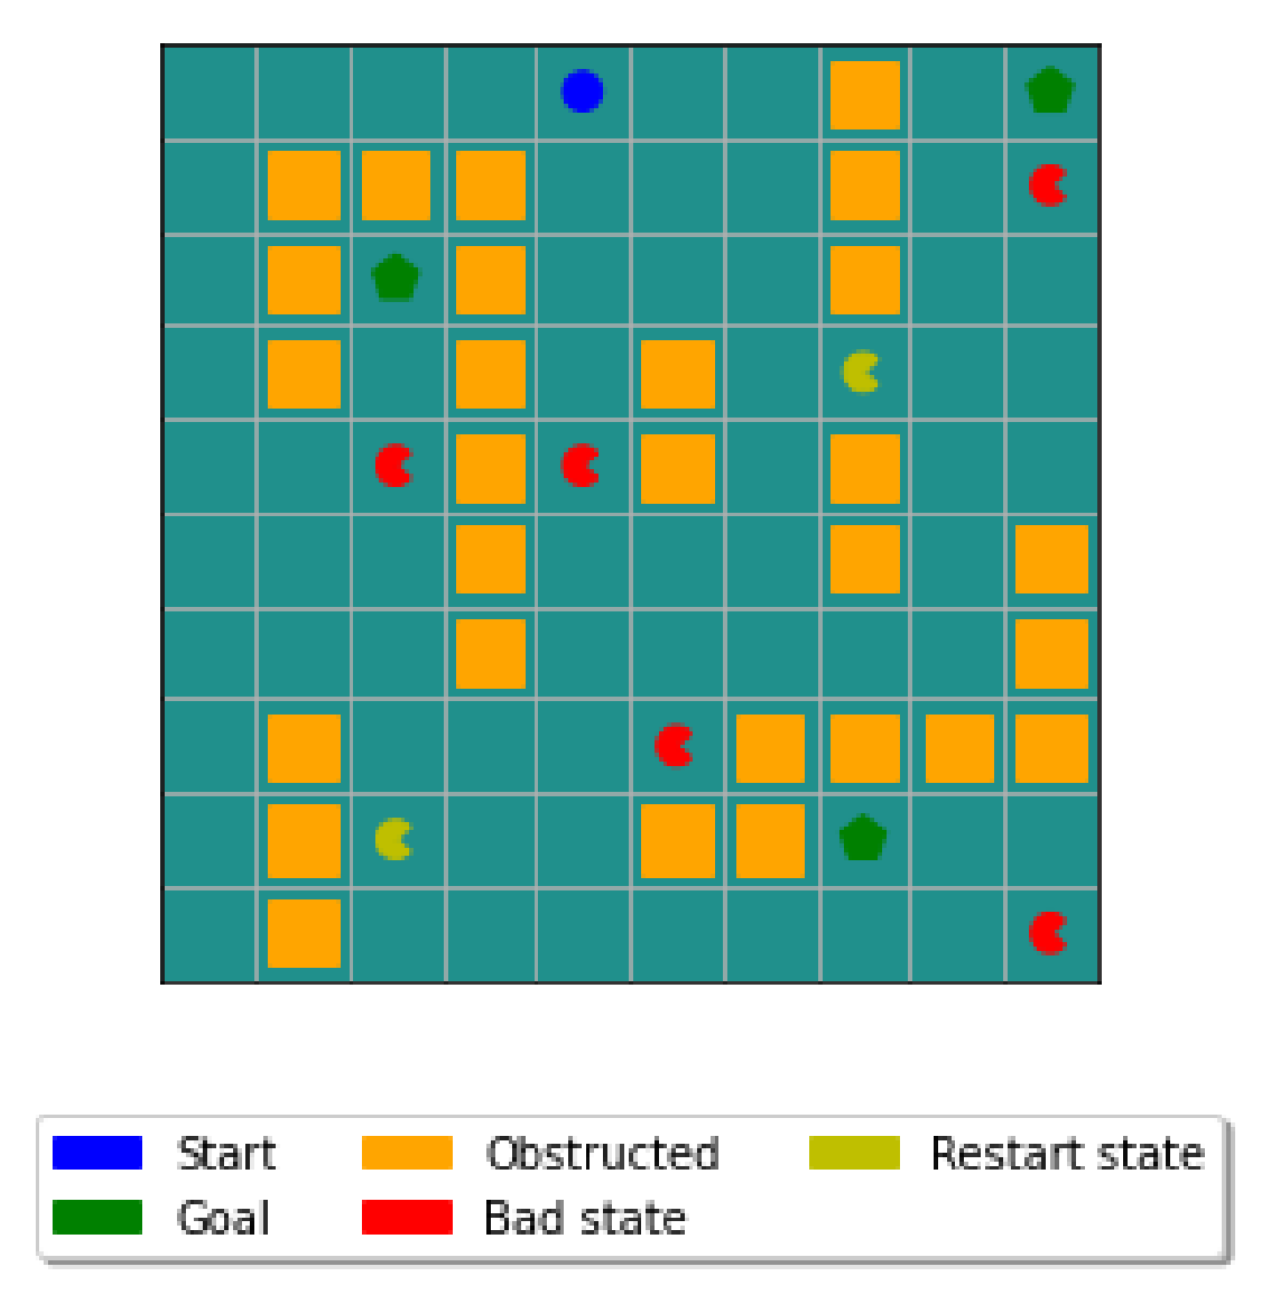

***Figure 1***

This is a grid world with 4 deterministic actions ('up', 'down', 'left', 'right'). The agent transitions to the next state determined by the direction of the action chosen with a probability of $p \in [0, 1]$. We also define a parameter called $b \in [0, 1]$ (Set $b=0.5$ for this assignment). Consider the direction of the action chosen as the agent's “North”. For example, if the action is 'left', it is the agent's North, and the agent's East would be the direction of the action 'up'. Figure 2 provides an illustration of the same. The agent transitions to the state West of the chosen action with probability $(1-p)\times b$, and to the East of the chosen action with probability $(1-p) \times (1-b)$.

 The environment may also have a wind blowing that can push the agent one **additional** cell to the right **after transitioning to the new state** with a probability of 0.4. An episode is terminated either when a goal is reached or when the timesteps exceed 100. Transitions that take you off the grid will not result in any change in state.

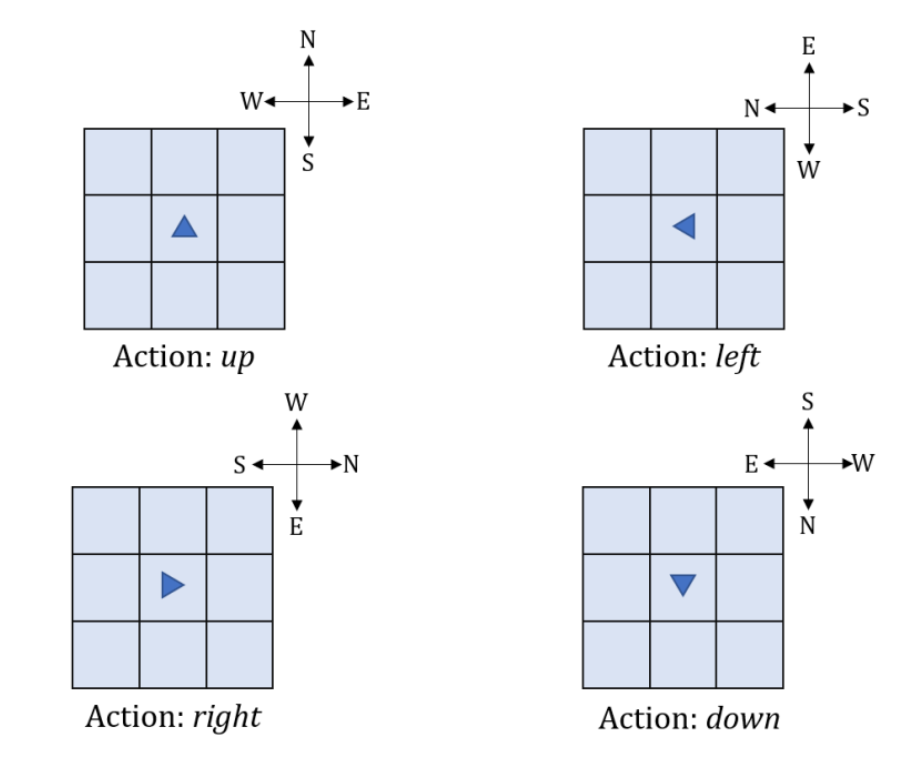

***Figure 2***

The dimensions of the grid are $10 \times 10$. The following types of states exist:

- ***Start state***: The agent starts from this state.
- ***Goal state***: The goal is to reach one of these states. There are 3 goal states in total.

- ***Obstructed state***: These are walls that prevent entry to the respective cells. Transition to these states will not result in any change.

- ***Bad state***: Entry into these states will incur a higher penalty than a normal state.
- ***Restart state***: Entry into these states will incur a very high penalty and will cause agent to teleport to the start state without the episode ending. Once the restart state is reached, no matter what action is chosen, it goes to the start state at the next step.
- ***Normal state***: None of the above. Entry into these states will incur a small penalty.


***Rewards***: -1 for normal states, -100 for restart states, -6 for bad states, +10 for goal states.

## Environment code

The code for the environment can be found below:

In [ ]:
from math import floor
import plotly
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import numpy as np

# Converts row_column format to state number
def row_col_to_seq(row_col, num_cols):
    return row_col[:,0] * num_cols + row_col[:,1]


# Converts state number to row_column format
def seq_to_col_row(seq, num_cols):
    r = floor(seq / num_cols)
    c = seq - r * num_cols
    return np.array([[r, c]])

class GridWorld:
    """
    Creates a gridworld object to pass to an RL algorithm.
    Parameters
    ----------
    num_rows : int
        The number of rows in the gridworld.
    num_cols : int
        The number of cols in the gridworld.
    start_state : numpy array of shape (1, 2), np.array([[row, col]])
        The start state of the gridworld (can only be one start state)
    goal_states : numpy arrany of shape (n, 2)
        The goal states for the gridworld where n is the number of goal
        states.
    """
    def __init__(self, num_rows, num_cols, start_state, goal_states, wind = False):
        self.num_rows = num_rows
        self.num_cols = num_cols
        self.start_state = start_state
        self.goal_states = goal_states
        self.obs_states = None
        self.bad_states = None
        self.num_bad_states = 0
        self.p_good_trans = None
        self.bias = None
        self.r_step = None
        self.r_goal = None
        self.r_dead = None
        self.gamma = 1
        self.wind = wind

    # mark obstructed cells
    def add_obstructions(self, obstructed_states=None, bad_states=None, restart_states=None):

        self.obs_states = obstructed_states
        self.bad_states = bad_states
        if bad_states is not None:
            self.num_bad_states = bad_states.shape[0]
        else:
            self.num_bad_states = 0
        self.restart_states = restart_states
        if restart_states is not None:
            self.num_restart_states = restart_states.shape[0]
        else:
            self.num_restart_states = 0

    def add_transition_probability(self, p_good_transition, bias):

        self.p_good_trans = p_good_transition
        self.bias = bias

    def add_rewards(self, step_reward, goal_reward, bad_state_reward=None, restart_state_reward = None):

        self.r_step = step_reward
        self.r_goal = goal_reward
        self.r_bad = bad_state_reward
        self.r_restart = restart_state_reward


    def create_gridworld(self):

        self.num_actions = 4
        self.num_states = self.num_cols * self.num_rows# +1
        self.start_state_seq = row_col_to_seq(self.start_state, self.num_cols)
        self.goal_states_seq = row_col_to_seq(self.goal_states, self.num_cols)

        # rewards structure
        self.R = self.r_step * np.ones((self.num_states, 1))
        #self.R[self.num_states-1] = 0
        self.R[self.goal_states_seq] = self.r_goal

        for i in range(self.num_bad_states):
            if self.r_bad is None:
                raise Exception("Bad state specified but no reward is given")
            bad_state = row_col_to_seq(self.bad_states[i,:].reshape(1,-1), self.num_cols)
            #print("bad states", bad_state)
            self.R[bad_state, :] = self.r_bad
        for i in range(self.num_restart_states):
            if self.r_restart is None:
                raise Exception("Restart state specified but no reward is given")
            restart_state = row_col_to_seq(self.restart_states[i,:].reshape(1,-1), self.num_cols)
            #print("restart_state", restart_state)
            self.R[restart_state, :] = self.r_restart

        # probability model
        if self.p_good_trans == None:
            raise Exception("Must assign probability and bias terms via the add_transition_probability method.")

        self.P = np.zeros((self.num_states,self.num_states,self.num_actions))
        for action in range(self.num_actions):
            for state in range(self.num_states):

                # check if the state is the goal state or an obstructed state - transition to end
                row_col = seq_to_col_row(state, self.num_cols)
                if self.obs_states is not None:
                    end_states = np.vstack((self.obs_states, self.goal_states))
                else:
                    end_states = self.goal_states

                if any(np.sum(np.abs(end_states-row_col), 1) == 0):
                    self.P[state, state, action] = 1

                # else consider stochastic effects of action
                else:
                    for dir in range(-1,2,1):

                        direction = self._get_direction(action, dir)
                        next_state = self._get_state(state, direction)
                        if dir == 0:
                            prob = self.p_good_trans
                        elif dir == -1:
                            prob = (1 - self.p_good_trans)*(self.bias)
                        elif dir == 1:
                            prob = (1 - self.p_good_trans)*(1-self.bias)

                        self.P[state, next_state, action] += prob

                # make restart states transition back to the start state with
                # probability 1
                if self.restart_states is not None:
                    if any(np.sum(np.abs(self.restart_states-row_col),1)==0):
                        next_state = row_col_to_seq(self.start_state, self.num_cols)
                        self.P[state,:,:] = 0
                        self.P[state,next_state,:] = 1

        return self

    def _get_direction(self, action, direction):

        left = [2,3,1,0]
        right = [3,2,0,1]
        if direction == 0:
            new_direction = action
        elif direction == -1:
            new_direction = left[action]
        elif direction == 1:
            new_direction = right[action]
        else:
            raise Exception("getDir received an unspecified case")
        return new_direction

    def _get_state(self, state, direction):

        row_change = [-1,1,0,0]
        col_change = [0,0,-1,1]
        row_col = seq_to_col_row(state, self.num_cols)
        row_col[0,0] += row_change[direction]
        row_col[0,1] += col_change[direction]

        # check for invalid states
        if self.obs_states is not None:
            if (np.any(row_col < 0) or
                np.any(row_col[:,0] > self.num_rows-1) or
                np.any(row_col[:,1] > self.num_cols-1) or
                np.any(np.sum(abs(self.obs_states - row_col), 1)==0)):
                next_state = state
            else:
                next_state = row_col_to_seq(row_col, self.num_cols)[0]
        else:
            if (np.any(row_col < 0) or
                np.any(row_col[:,0] > self.num_rows-1) or
                np.any(row_col[:,1] > self.num_cols-1)):
                next_state = state
            else:
                next_state = row_col_to_seq(row_col, self.num_cols)[0]

        return next_state

    def reset(self):
      return int(self.start_state_seq)

    def step(self, state, action):
        p, r = 0, np.random.random()
        for next_state in range(self.num_states):

            p += self.P[state, next_state, action]

            if r <= p:
                break

        if(self.wind and np.random.random() < 0.4):

          arr = self.P[next_state, :, 3]
          next_next = np.where(arr == np.amax(arr))
          next_next = next_next[0][0]
          return next_next, self.R[next_next]
        else:
          return next_state, self.R[next_state]

    def visualize_gridworld(self):

        # create a 2D grid with empty cells
        grid_world_2D_array = np.ones((self.num_rows, self.num_cols))*ord("E")

        grid_world_2D_array[self.goal_states[:,0],self.goal_states[:,1]]= ord("G")
        grid_world_2D_array[self.obs_states[:,0],self.obs_states[:,1]]= ord("O")
        grid_world_2D_array[self.start_state[:,0],self.start_state[:,1]]= ord("S")
        grid_world_2D_array[self.bad_states[:,0],self.bad_states[:,1]]= ord("B")
        grid_world_2D_array[self.restart_states[:,0],self.restart_states[:,1]]= ord("R")

        grid_world_2D_array_colours = np.ones((self.num_rows, self.num_cols, 3))

        grid_world_2D_array_colours[grid_world_2D_array== ord("G")] =[0,1,0]
        grid_world_2D_array_colours[grid_world_2D_array== ord("O")] =[1,0.65,0]
        grid_world_2D_array_colours[grid_world_2D_array== ord("S")] =[0,0,1]
        grid_world_2D_array_colours[grid_world_2D_array== ord("B")] =[1,0,0]
        grid_world_2D_array_colours[grid_world_2D_array== ord("R")] =[1,1,0]

        fig = px.imshow(grid_world_2D_array_colours)

        state_label = np.empty_like(grid_world_2D_array,
                                    dtype ="<U10")

        state_label[grid_world_2D_array == ord("E")] ="Empty"
        state_label[grid_world_2D_array == ord("G")] ="Goal"
        state_label[grid_world_2D_array == ord("B")] ="Bad"
        state_label[grid_world_2D_array == ord("S")] ="Start"
        state_label[grid_world_2D_array == ord("R")] ="Restart"
        state_label[grid_world_2D_array == ord("O")] ="Obstacle"

        fig.update(data=[{'customdata': state_label,
                          'hovertemplate': 'x: %{x}<br>y: %{y}<br>State: %{customdata}'}])
        # add vertical and horizontal lines
        [fig.add_vline(x=i, line_width=2, line_dash="solid", line_color="Grey") for i in np.arange(-0.5,10)]
        [fig.add_hline(y=i, line_width=2, line_dash="solid", line_color="Grey") for i in np.arange(-0.5,10)]

        # ensure each row and column is numbered/labeled
        fig.update_layout(
            title ="Grid World Vizualization <br>Hover over to a cell for information",
            xaxis = dict(
                tickmode='linear',
                side='top',
                dtick=1),
            yaxis = dict(
                tickmode='linear',
                dtick=1)
        )
        fig.show()


## Environment instantiation

In [ ]:
# specify world parameters

# size of the grid
num_cols = 10
num_rows = 10

# coordinates of the cells representing obstruction
obstructions = np.array([[0,7],[1,1],[1,2],[1,3],[1,7],[2,1],[2,3],
                         [2,7],[3,1],[3,3],[3,5],[4,3],[4,5],[4,7],
                         [5,3],[5,7],[5,9],[6,3],[6,9],[7,1],[7,6],
                         [7,7],[7,8],[7,9],[8,1],[8,5],[8,6],[9,1]])

# lsit of bad states
bad_states = np.array([[1,9],[4,2],[4,4],[7,5],[9,9]])

# list of restart states
restart_states = np.array([[3,7],[8,2]])

# starting position
start_state = np.array([[0,4]])

# list of goal states i.e. terminal states
goal_states = np.array([[0,9],[2,2],[8,7]])

# create the environment's model
gw = GridWorld(num_rows=num_rows,
               num_cols=num_cols,
               start_state=start_state,
               goal_states=goal_states,
               wind = False)

gw.add_obstructions(obstructed_states=obstructions,
                    bad_states=bad_states,
                    restart_states=restart_states)

gw.add_rewards(step_reward=-1,
               goal_reward=10,
               bad_state_reward=-6,
               restart_state_reward=-100)
gw.add_transition_probability(p_good_transition=0.7,
                              bias=0.5)
env_s1_p1 = gw.create_gridworld()

In [ ]:
# specify world parameters

# size of the grid
num_cols = 10
num_rows = 10

# coordinates of the cells representing obstruction
obstructions = np.array([[0,7],[1,1],[1,2],[1,3],[1,7],[2,1],[2,3],
                         [2,7],[3,1],[3,3],[3,5],[4,3],[4,5],[4,7],
                         [5,3],[5,7],[5,9],[6,3],[6,9],[7,1],[7,6],
                         [7,7],[7,8],[7,9],[8,1],[8,5],[8,6],[9,1]])

# lsit of bad states
bad_states = np.array([[1,9],[4,2],[4,4],[7,5],[9,9]])

# list of restart states
restart_states = np.array([[3,7],[8,2]])

# starting position
start_state = np.array([[3,6]])

# list of goal states i.e. terminal states
goal_states = np.array([[0,9],[2,2],[8,7]])

# create the environment's model
gw = GridWorld(num_rows=num_rows,
               num_cols=num_cols,
               start_state=start_state,
               goal_states=goal_states,
               wind = False)

gw.add_obstructions(obstructed_states=obstructions,
                    bad_states=bad_states,
                    restart_states=restart_states)

gw.add_rewards(step_reward=-1,
               goal_reward=10,
               bad_state_reward=-6,
               restart_state_reward=-100)
gw.add_transition_probability(p_good_transition=0.7,
                              bias=0.5)
env_s2_p1 = gw.create_gridworld()

In [ ]:
# specify world parameters

# size of the grid
num_cols = 10
num_rows = 10

# coordinates of the cells representing obstruction
obstructions = np.array([[0,7],[1,1],[1,2],[1,3],[1,7],[2,1],[2,3],
                         [2,7],[3,1],[3,3],[3,5],[4,3],[4,5],[4,7],
                         [5,3],[5,7],[5,9],[6,3],[6,9],[7,1],[7,6],
                         [7,7],[7,8],[7,9],[8,1],[8,5],[8,6],[9,1]])

# lsit of bad states
bad_states = np.array([[1,9],[4,2],[4,4],[7,5],[9,9]])

# list of restart states
restart_states = np.array([[3,7],[8,2]])

# starting position
start_state = np.array([[0,4]])

# list of goal states i.e. terminal states
goal_states = np.array([[0,9],[2,2],[8,7]])

# create the environment's model
gw = GridWorld(num_rows=num_rows,
               num_cols=num_cols,
               start_state=start_state,
               goal_states=goal_states,
               wind = False)

gw.add_obstructions(obstructed_states=obstructions,
                    bad_states=bad_states,
                    restart_states=restart_states)

gw.add_rewards(step_reward=-1,
               goal_reward=10,
               bad_state_reward=-6,
               restart_state_reward=-100)
gw.add_transition_probability(p_good_transition=1,
                              bias=0.5)
env_s1_p2 = gw.create_gridworld()

In [ ]:
# specify world parameters

# size of the grid
num_cols = 10
num_rows = 10

# coordinates of the cells representing obstruction
obstructions = np.array([[0,7],[1,1],[1,2],[1,3],[1,7],[2,1],[2,3],
                         [2,7],[3,1],[3,3],[3,5],[4,3],[4,5],[4,7],
                         [5,3],[5,7],[5,9],[6,3],[6,9],[7,1],[7,6],
                         [7,7],[7,8],[7,9],[8,1],[8,5],[8,6],[9,1]])

# lsit of bad states
bad_states = np.array([[1,9],[4,2],[4,4],[7,5],[9,9]])

# list of restart states
restart_states = np.array([[3,7],[8,2]])

# starting position
start_state = np.array([[3,6]])

# list of goal states i.e. terminal states
goal_states = np.array([[0,9],[2,2],[8,7]])

# create the environment's model
gw = GridWorld(num_rows=num_rows,
               num_cols=num_cols,
               start_state=start_state,
               goal_states=goal_states,
               wind = False)

gw.add_obstructions(obstructed_states=obstructions,
                    bad_states=bad_states,
                    restart_states=restart_states)

gw.add_rewards(step_reward=-1,
               goal_reward=10,
               bad_state_reward=-6,
               restart_state_reward=-100)
gw.add_transition_probability(p_good_transition=1,
                              bias=0.5)
env_s2_p2 = gw.create_gridworld()

## Visualize the grid world

In [ ]:
# visualize the grid world configuration
env_s1_p1.visualize_gridworld()

In [ ]:
env_s2_p1.visualize_gridworld()

## List environment variables

In [ ]:
print("Number of actions", env_s1_p1.num_actions) #0 -> UP, 1-> DOWN, 2 -> LEFT, 3-> RIGHT
print("Number of states", env_s1_p1.num_states)
print("start state", env_s1_p1.start_state_seq)
print("goal state(s)", env_s1_p1.goal_states_seq)

Number of actions 4
Number of states 100
start state [4]
goal state(s) [ 9 22 87]


The $env.step()$ function takes as arguments the current state and action, and returns the reward and next state. The appropriate termination conditions have to be specified by the student in the code. $env.reset()$ resets the environment.

## Tasks
- Implement SARSA and Q-Learning.
- For SARSA, there are a total of $8$ configurations:
  - set $p = 1$
  - wind could take one of two values, `True` or `False`
  - start state could take one of two values: `(0, 4)` or `(3, 6)`
  - exploration strategy could take one of two values: $\epsilon$-greedy or softmax
- For Q-learning, there are a total of $8$ configurations:
  - $p = 1$ or $p = 0.7$
  - set `wind = False`
  - start state could take one of two values: `(0, 4)` or `(3, 6)`
  - exploration strategy could take one of two values: $\epsilon$-greedy or softmax

- There are a total of $16$ configurations.
- For each of the $16$ configurations, determine the best set of hyperparameters (i.e. $ϵ$ in $ϵ$-greedy exploration, temperature $\beta$ in softmax exploration, learning rate $\alpha$, and discount factor $\gamma$) which maximize reward per episode over atleast 100 runs. Plot the following:
  1. Reward curves and the number of steps to reach the goal in each episode (during the training phase with the best hyperparameters).
  2. Heatmap of the grid with state visit counts, i.e., the number of times each state was visited throughout the training phase.
  3. Heatmap of the grid with Q values after training is complete, and optimal actions for the best policy.
- Try following set of values for each of the hyperparameters, for each of the configurations:

  a. learning rate ($α$) = [0.001, 0.01, 0.1, 1.0]

  b. discount factor ($γ$) = [0.7, 0.8, 0.9, 1.0]

  c. epsilon in $ϵ$-greedy = [0.001, 0.01, 0.05, 0.1] or
  
  Temperature in soft max ($τ$) = [0.01, 0.1, 1, 2]

For each of the algorithm, provide a written description of the policy learnt, explaining
the behavior of the agent, and your choice of hyperparameters. This description should
also provide information about how the behavior changes with and without the wind, for
different levels of stochasticity and for different start states.

The report can be organized in following manner:

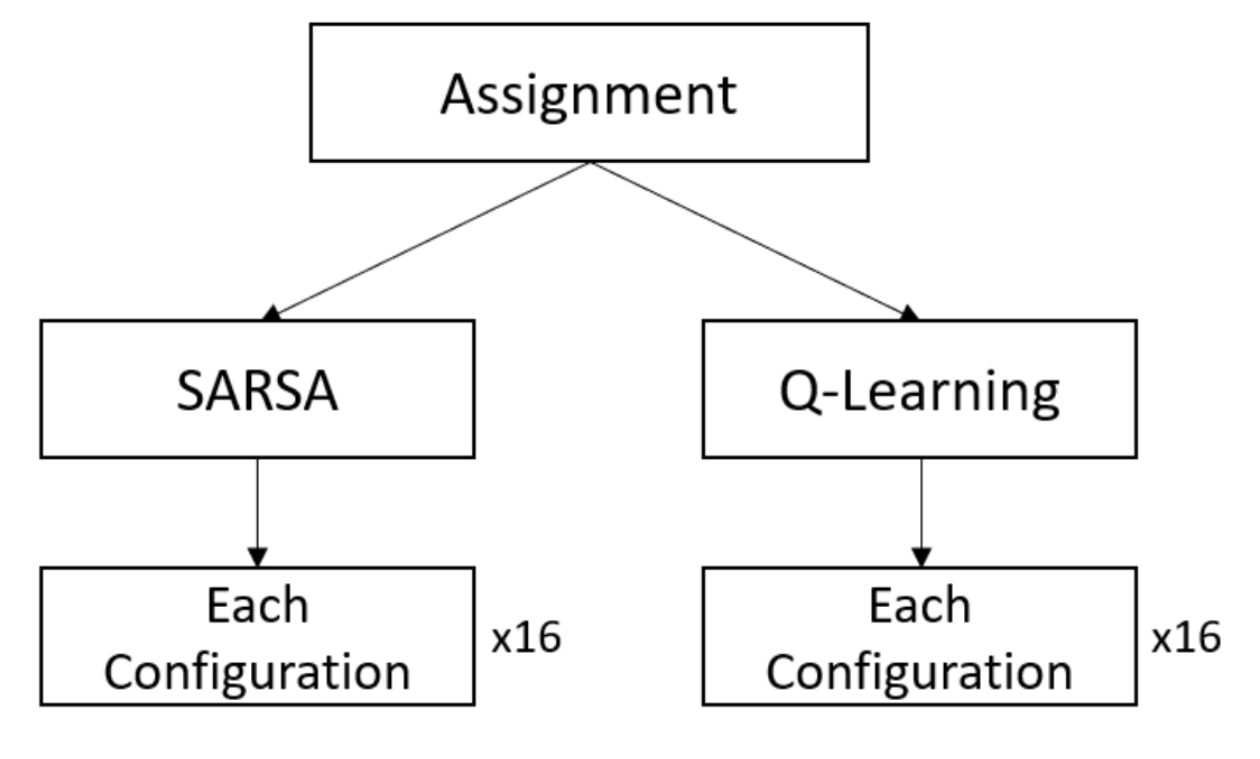

## Configurations

There are total (~~32~~)16 configurations (~~16~~)8 each for SARSA and Q-Learning), each of which carry (~~2~~)4 marks.

Use below template for each of the configurations.

Hint: For reproducible results set random state appropriately.

In [ ]:
def action_softmax(Q, tau):
        x = Q/tau
        action_probabs = sc.special.softmax(x - np.max(x))
        chosen_action = np.random.choice(len(Q), p = action_probabs)
        return chosen_action


def action_epsilon_greedy(Q, epsilon):
        if np.random.rand() < epsilon:
            #explore
            chosen_action = np.random.choice(len(Q))
        else:
            chosen_action = np.argmax(Q, axis=0)
        return chosen_action

In [ ]:
def sarsa(env, alpha, gamma, epsilon=None, temperature=None, wind=False):
        num_states = env.num_states
        num_actions = env.num_actions
        num_episodes = 1000
        num_agents = 50
        env.wind = wind

        state_visits = np.zeros(num_states)

        Q_vals_total = np.zeros((num_states, num_actions))

        rewards_per_agent = []
        steps_per_agent = []
        #contains inner lists as elems
        #each inner list -> collection over each episode
        for agent in range(num_agents):
            q_values = np.zeros((num_states, num_actions))

            rewards_per_episode = []
            steps_per_episode = []

            for i in range(num_episodes):

                state = env.reset()
                state_visits[state] += 1
                done = False
                total_reward = 0
                total_steps = 0
                #1st action from intial state
                if epsilon is not None:
                    action = action_epsilon_greedy(q_values[state], epsilon)
                elif temperature is not None:
                    action = action_softmax(q_values[state], temperature)
                else:
                    raise ValueError("Either epsilon or temperature should be provided.")

                while not done and total_steps<=100:
                    next_state, reward = env.step(state, action)
                    #transition to next state
                    state_visits[next_state] += 1
                    #increment visit

                    if epsilon is not None:
                        next_action = action_epsilon_greedy(q_values[next_state], epsilon)
                    elif temperature is not None:
                        next_action = action_softmax(q_values[next_state], temperature)
                    else:
                        raise ValueError("Either epsilon or temperature should be provided.")

                    q_values[state, action] += alpha * (reward + gamma * q_values[next_state,next_action] - q_values[state, action])

                    state = next_state
                    action = next_action

                    total_reward += reward
                    total_steps += 1

                    done = (state in env.goal_states_seq)

                rewards_per_episode.append(total_reward)
                steps_per_episode.append(total_steps)

            Q_vals_total += q_values
            rewards_per_agent.append(rewards_per_episode)
            steps_per_agent.append(steps_per_episode)

        average_rewards_per_episode = np.mean(rewards_per_agent, axis=0)
        average_steps_per_episode = np.mean(steps_per_agent, axis=0)

        return average_rewards_per_episode, average_steps_per_episode, state_visits, Q_vals_total

In [ ]:
def q_learning(env, alpha, gamma, epsilon=None, temperature=None, wind=False):
        num_states = env.num_states
        num_actions = env.num_actions
        num_episodes = 1000
        num_agents = 50
        env.wind = wind

        state_visits = np.zeros(num_states)

        Q_vals_total = np.zeros((num_states, num_actions))

        rewards_per_agent = []
        steps_per_agent = []
        #contains inner lists as elems
        #each inner list -> collection over each episode
        for agent in range(num_agents):
            q_values = np.zeros((num_states, num_actions))

            rewards_per_episode = []
            steps_per_episode = []

            for i in range(num_episodes):

                state = env.reset()
                state_visits[state] += 1
                done = False
                total_reward = 0
                total_steps = 0
                #1st action from intial state
                if epsilon is not None:
                    action = action_epsilon_greedy(q_values[state], epsilon)
                elif temperature is not None:
                    action = action_softmax(q_values[state], temperature)
                else:
                    raise ValueError("Either epsilon or temperature should be provided.")

                while not done and total_steps<=100:
                    next_state, reward = env.step(state, action)
                    #transition to next state
                    state_visits[next_state] += 1
                    #increment visit

                    if epsilon is not None:
                        next_action = action_epsilon_greedy(q_values[next_state], epsilon)
                    elif temperature is not None:
                        next_action = action_softmax(q_values[next_state], temperature)
                    else:
                        raise ValueError("Either epsilon or temperature should be provided.")

                    target_action = np.max(q_values[next_state,:])
                    q_values[state, action] += alpha * (reward + gamma * target_action - q_values[state, action])

                    state = next_state
                    action = next_action

                    total_reward += reward
                    total_steps += 1

                    done = (state in env.goal_states_seq)

                rewards_per_episode.append(total_reward)
                steps_per_episode.append(total_steps)

            Q_vals_total += q_values
            rewards_per_agent.append(rewards_per_episode)
            steps_per_agent.append(steps_per_episode)

        average_rewards_per_episode = np.mean(rewards_per_agent, axis=0)
        average_steps_per_episode = np.mean(steps_per_agent, axis=0)

        return average_rewards_per_episode, average_steps_per_episode, state_visits, Q_vals_total

In [ ]:
#Hyperparams
alpha = [0.001, 0.01, 0.1, 1.0]
gamma = [0.7, 0.8, 0.9, 1.0]
epsilon = [0.001, 0.01, 0.05, 0.1]
temperature =[0.01, 0.1, 1, 2]

### (1) Configuration id <<1>>

#### Configuration Parameters
Learning algorithm = SARSA

Wind = True

Start State = (0,4)

Value of $p$ = 1

Exploration strategy = epsilon-greedy

Train the agent

In [ ]:
rewards, steps, state_visits, q_values = sarsa(env_s1_p2, 1.0, 0.9, epsilon=0.001, wind=True)

1. Plot reward curves (during the training phase with the best hyperparameters).

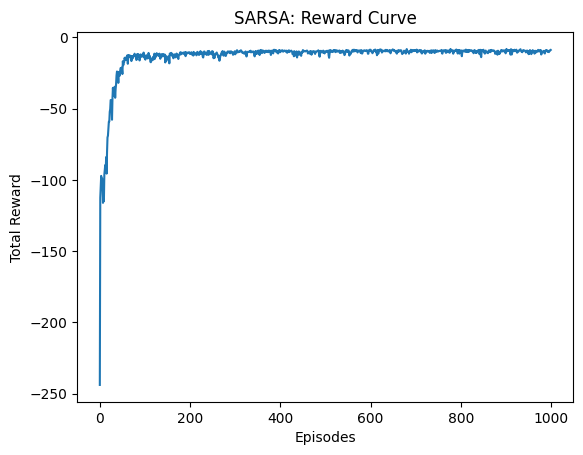

In [ ]:
plt.plot(rewards)
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.title('SARSA: Reward Curve')
plt.show()

2. Plot the number of steps to reach the goal in each episode (during the training phase with the best hyperparameters).

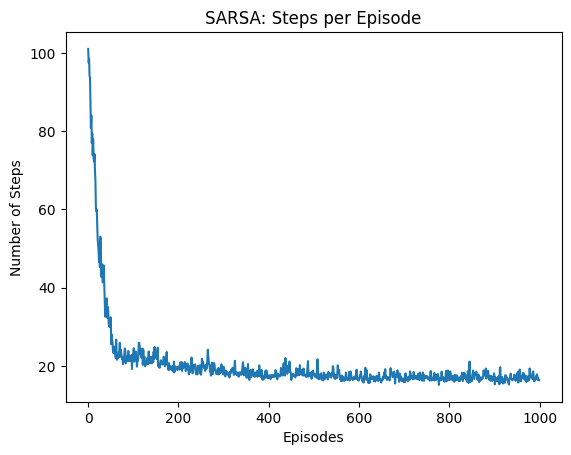

In [ ]:
plt.plot(steps)
plt.xlabel('Episodes')
plt.ylabel('Number of Steps')
plt.title('SARSA: Steps per Episode')
plt.show()

3. Heatmap of the grid with state visit counts, i.e., the number of times each state was visited throughout the training phase.

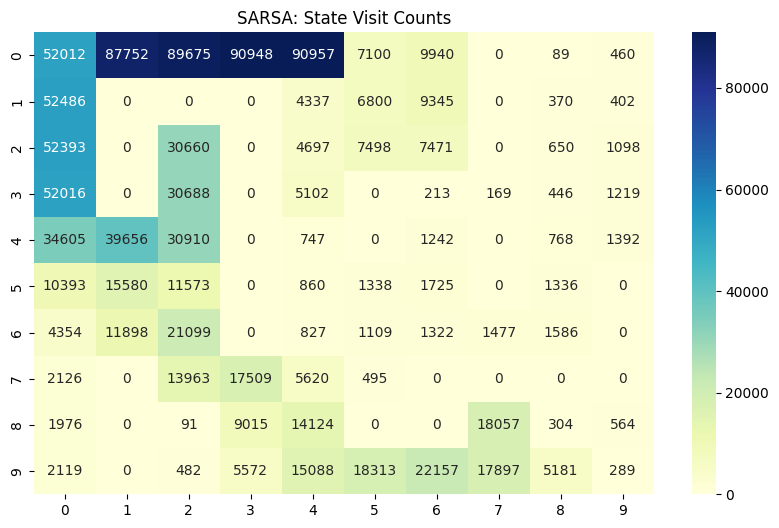

In [ ]:
state_visits_2d = state_visits.reshape((num_rows, num_rows))
plt.figure(figsize=(10, 6))
sns.heatmap(state_visits_2d, annot=True, fmt=".0f",
            cmap="YlGnBu",  cbar=True)
plt.title('SARSA: State Visit Counts')
plt.show()

4. Heatmap of the grid with Q values after training is complete, and optimal actions for the best policy.

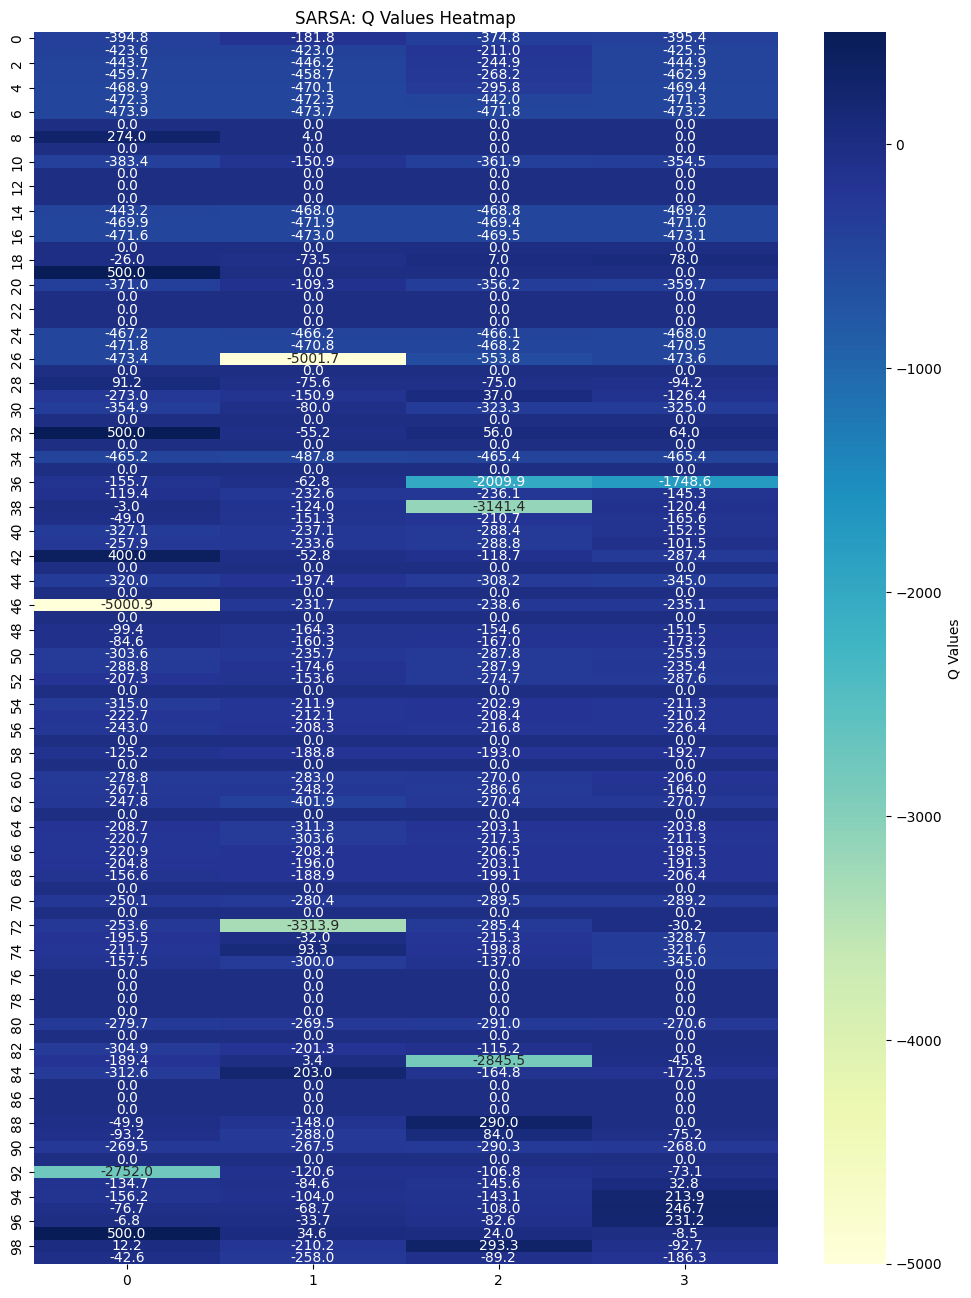

In [ ]:
q_values_max_action = np.argmax(q_values, axis=1)

plt.figure(figsize=(12, 16))
sns.heatmap(q_values, annot=True, fmt=".1f", cmap="YlGnBu", cbar_kws={'label': 'Q Values'})

plt.title('SARSA: Q Values Heatmap')
plt.show()

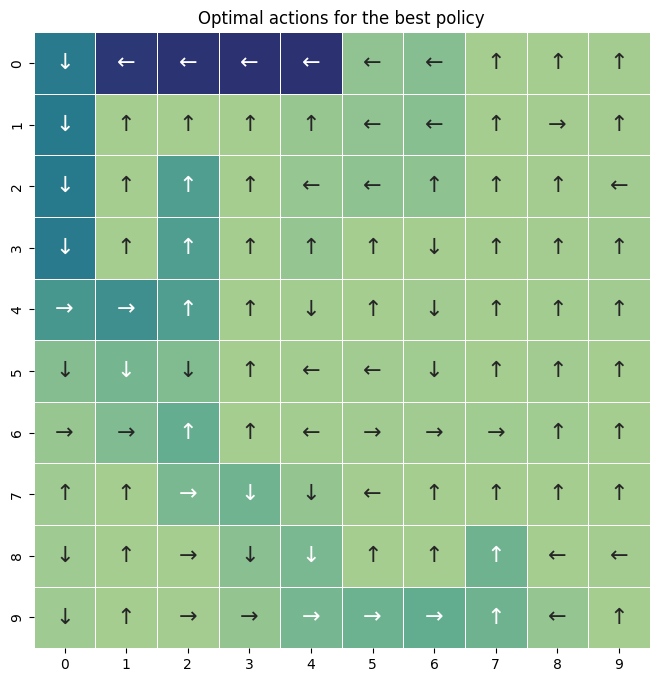

In [ ]:
max_indices = np.argmax(q_values, axis=1)
directions = {0: '↑', 1: '↓', 2: '←', 3: '→'}
direction_labels = np.vectorize(lambda x: directions[x])(max_indices)
direction_grid = direction_labels.reshape((10, 10))

plt.figure(figsize=(10, 8))
sns.heatmap(state_visits_2d, annot=direction_grid, fmt='',cmap="crest",
            cbar=False, linewidths=.5, square=True, annot_kws={'size': 16})
plt.title('Optimal actions for the best policy')
plt.show()

**Analysis 1:**


*   The best choice of hyperparameters for the above config are (alpha=1.0, gamma=0.9, epsilon=0.001).
*   The agent start with a reward = -100 amd attains its max reward close to 0 after 50 episodes and then saturates thereafter.

*   Initially the agent took 100 steps to reach the goal but then after 200 episodes it just took 20 steps to reach the goal


---











**Analysis 2:**

*   The agent takes its 1st step towards the left from the start state (0,4) majority of the times

*   But due to a stochasticity of 1, it tends to explore nearby states

*   With Wind, the agent moves towards the right state with a 40% probab and that is clearly visible from (4,2)->(5,2) and (4,3)->(5,3) and in many other states where the right state is not obstructed

* Agents visits the 3rd goal state (8,7) half of the times it has visited the 1st goal state (2,2)  

---



### (1) Configuration id 2

#### Configuration Parameters
Learning algorithm = SARSA

Wind = True

Start State = (0,4)

Value of $p$ = 1

Exploration strategy = softmax

Train the agent

In [ ]:
rewards, steps, state_visits, q_values = sarsa(env_s1_p2, 1.0, 1.0, temperature=0.1, wind=True)

1. Plot reward curves (during the training phase with the best hyperparameters).

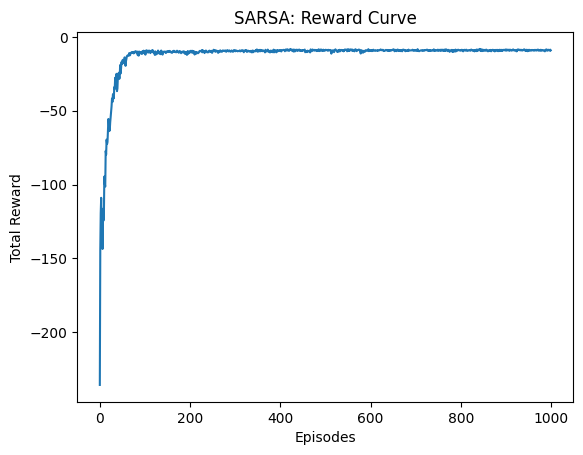

In [ ]:
plt.plot(rewards)
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.title('SARSA: Reward Curve')
plt.show()

2. Plot the number of steps to reach the goal in each episode (during the training phase with the best hyperparameters).

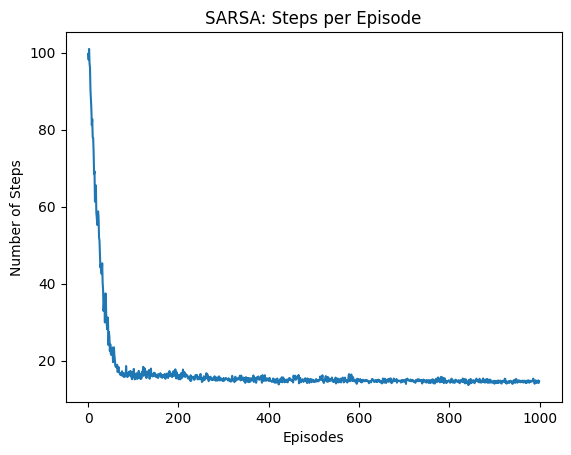

In [ ]:
plt.plot(steps)
plt.xlabel('Episodes')
plt.ylabel('Number of Steps')
plt.title('SARSA: Steps per Episode')
plt.show()

3. Heatmap of the grid with state visit counts, i.e., the number of times each state was visited throughout the training phase.

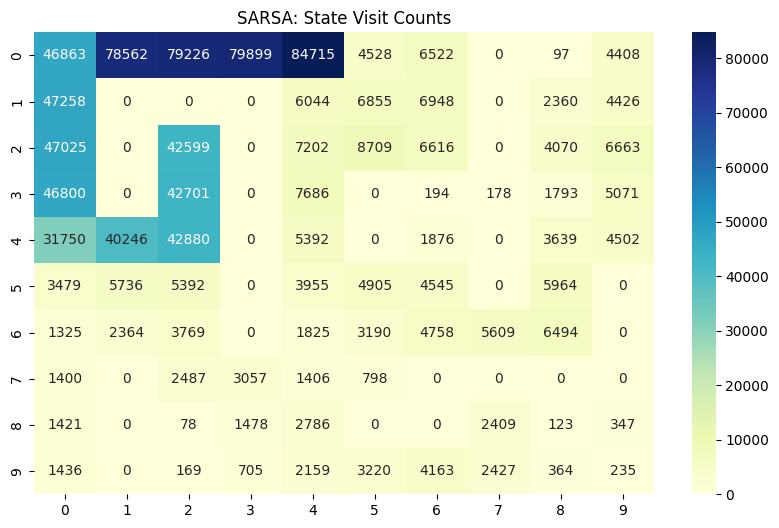

In [ ]:
state_visits_2d = state_visits.reshape((num_rows, num_rows))
plt.figure(figsize=(10, 6))
sns.heatmap(state_visits_2d, annot=True, fmt=".0f",
            cmap="YlGnBu",  cbar=True)
plt.title('SARSA: State Visit Counts')
plt.show()

4. Heatmap of the grid with Q values after training is complete, and optimal actions for the best policy.

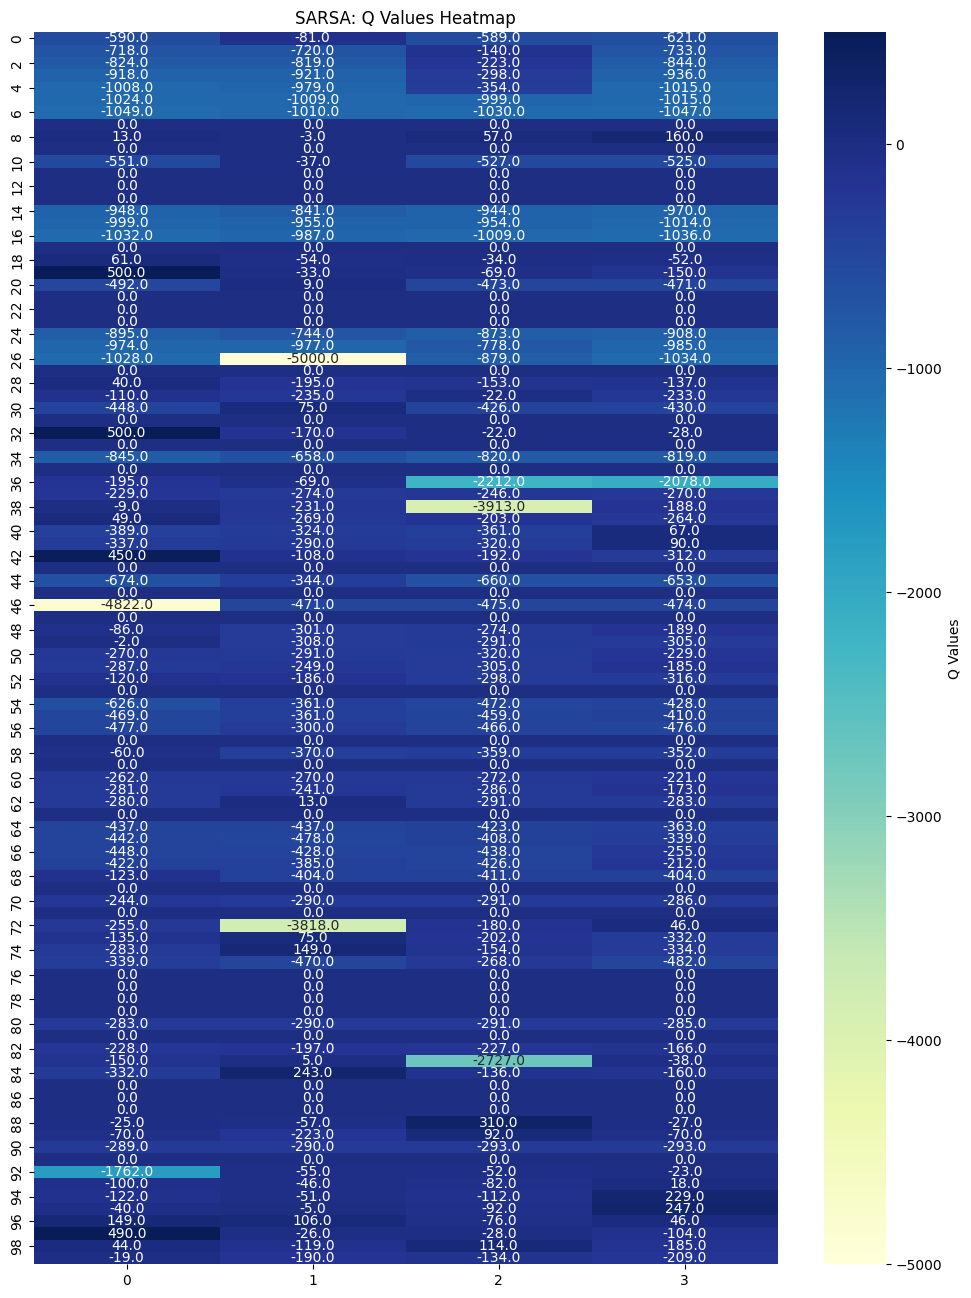

In [ ]:
plt.figure(figsize=(12, 16))
sns.heatmap(q_values, annot=True, fmt=".1f", cmap="YlGnBu", cbar_kws={'label': 'Q Values'})
plt.title('SARSA: Q Values Heatmap')
plt.show()

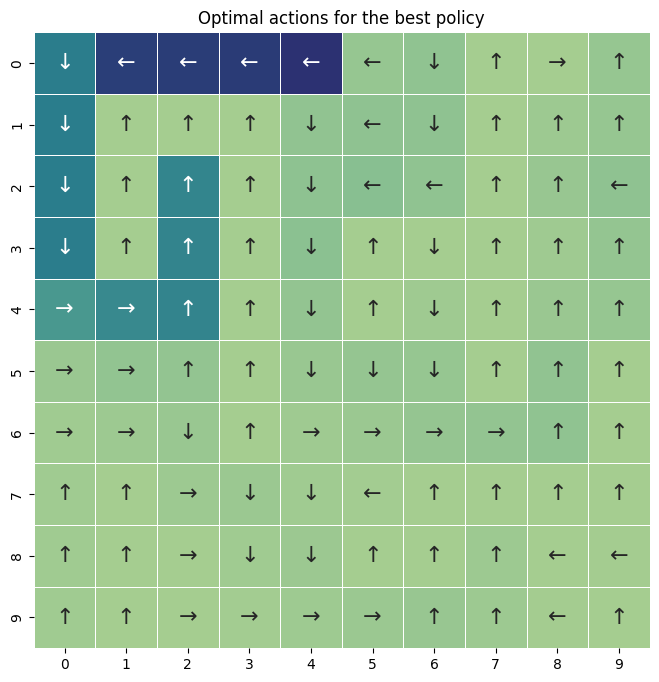

In [ ]:
max_indices = np.argmax(q_values, axis=1)
directions = {0: '↑', 1: '↓', 2: '←', 3: '→'}
direction_labels = np.vectorize(lambda x: directions[x])(max_indices)
direction_grid = direction_labels.reshape((10, 10))

plt.figure(figsize=(10, 8))
sns.heatmap(state_visits_2d, annot=direction_grid, fmt='',cmap="crest",
            cbar=False, linewidths=.5, square=True, annot_kws={'size': 16})
plt.title('Optimal actions for the best policy')
plt.show()

**Analysis 1:**


*   The best choice of hyperparameters for the above config are (alpha=1.0, gamma=1.0, temperature=0.1).
*   The agent  starts with a reward = -200 and then converges to approx 0 rewards after 50 episodes

*   Initially the agent took 100 steps to reach the goal but then after 100 episodes it converges to 20 steps


---

**Analysis 2:**


*   The agent takes its 1st step towards the left from the start state (0,4) majority of the times

*   But due to a stochasticity of 1, it tends to explore nearby states

*   With Wind, the agent moves towards the right state with a 40% probab and that is clearly visible from (4,2)->(5,2) and (4,3)->(5,3) and in many other states where the right state is not obstructed, but it is not as explorative as epsilon greedy

* With Softmax, the agent just sticks to one goal state (2,2) and majority of the times choses actions that tend to visit the 1st goal state (2,2)
---



### (1) Configuration id <<3>>

#### Configuration Parameters
Learning algorithm = SARSA

Wind = True

Start State = (3,6)

Value of $p$ = 1

Exploration strategy = epsilon-greedy

Train the agent

In [ ]:
rewards, steps, state_visits, q_values = sarsa(env_s2_p2, 1.0, 1.0, epsilon=0.001, wind=True)

1. Plot reward curves (during the training phase with the best hyperparameters).

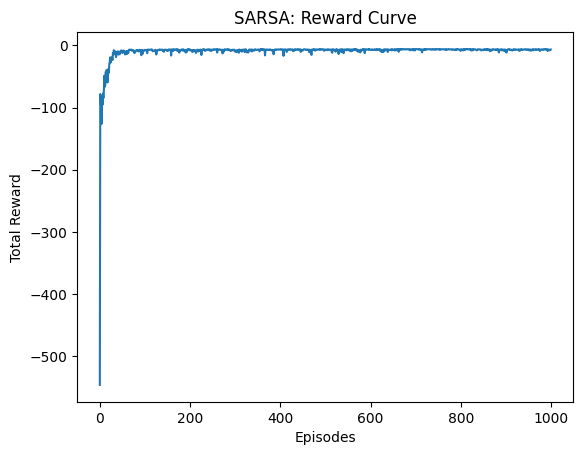

In [ ]:
plt.plot(rewards)
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.title('SARSA: Reward Curve')
plt.show()

2. Plot the number of steps to reach the goal in each episode (during the training phase with the best hyperparameters).

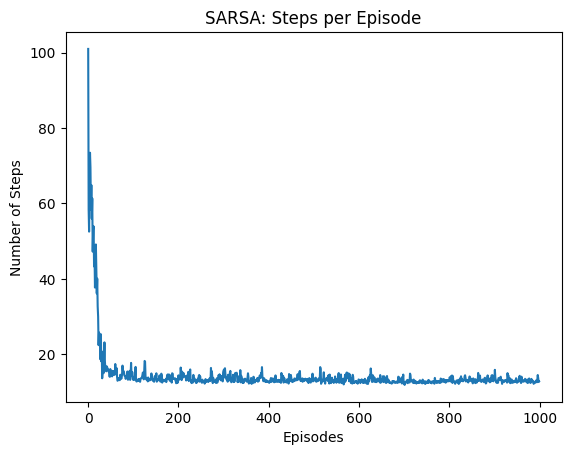

In [ ]:
plt.plot(steps)
plt.xlabel('Episodes')
plt.ylabel('Number of Steps')
plt.title('SARSA: Steps per Episode')
plt.show()

3. Heatmap of the grid with state visit counts, i.e., the number of times each state was visited throughout the training phase.

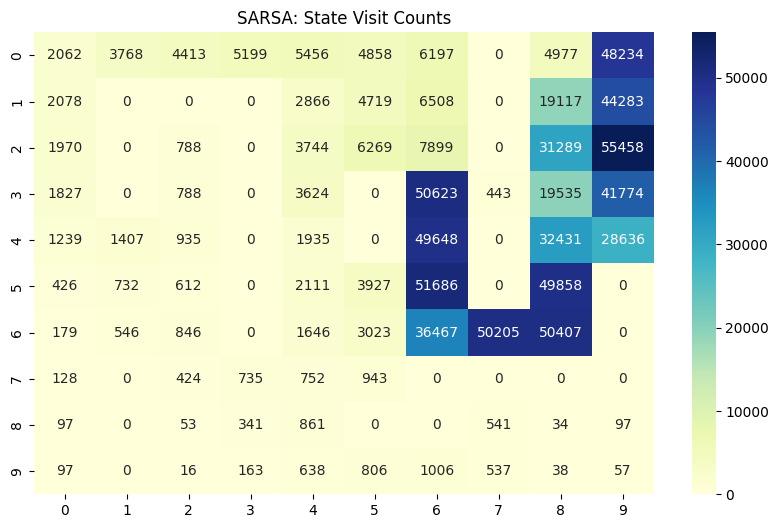

In [ ]:
state_visits_2d = state_visits.reshape((num_rows, num_rows))
plt.figure(figsize=(10, 6))
sns.heatmap(state_visits_2d, annot=True, fmt=".0f",
            cmap="YlGnBu",  cbar=True)
plt.title('SARSA: State Visit Counts')
plt.show()

4. Heatmap of the grid with Q values after training is complete, and optimal actions for the best policy.

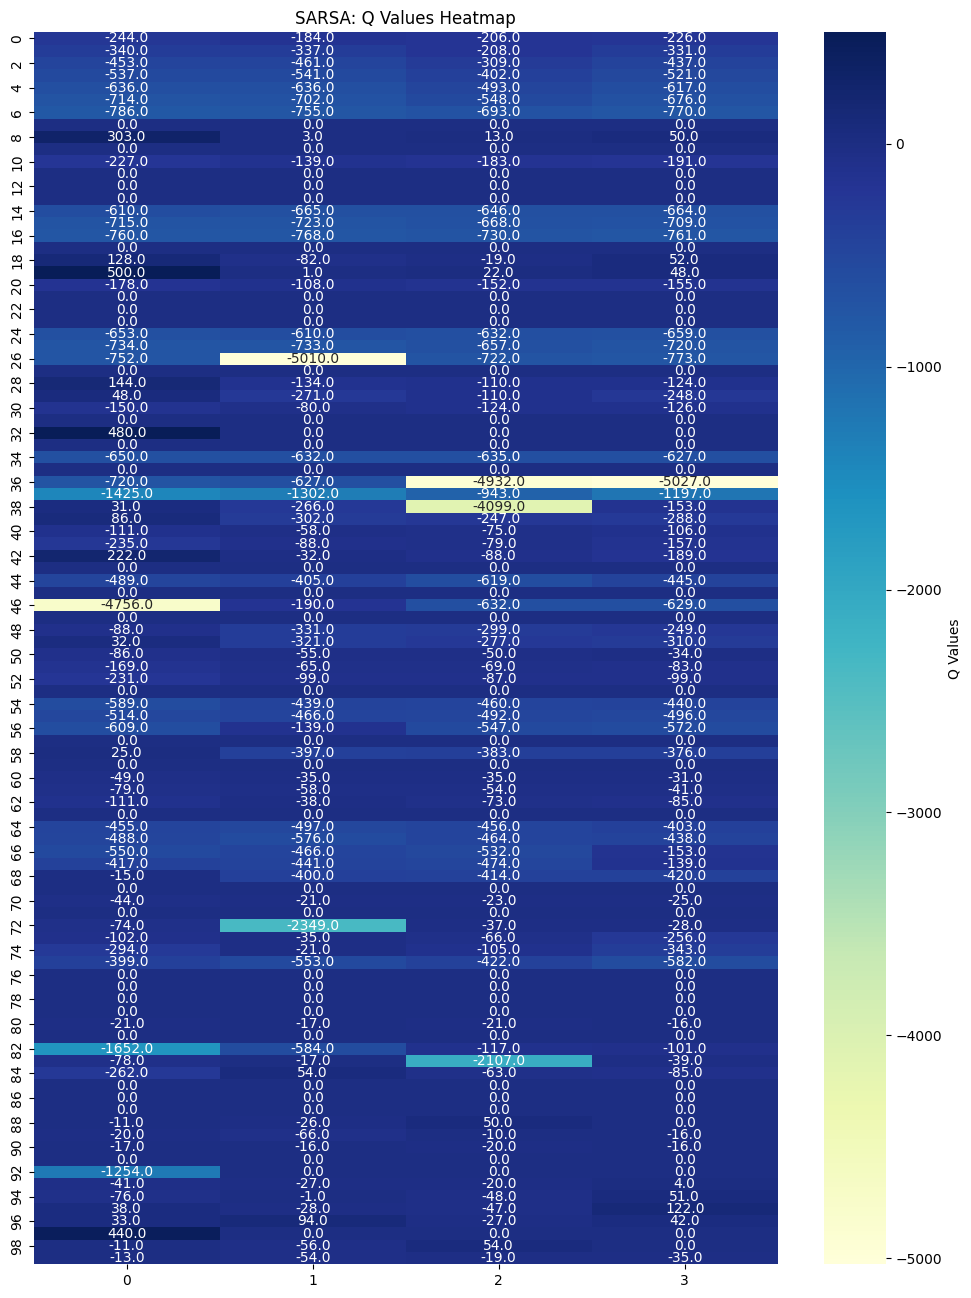

In [ ]:
plt.figure(figsize=(12, 16))
sns.heatmap(q_values, annot=True, fmt=".1f", cmap="YlGnBu", cbar_kws={'label': 'Q Values'})
plt.title('SARSA: Q Values Heatmap')
plt.show()

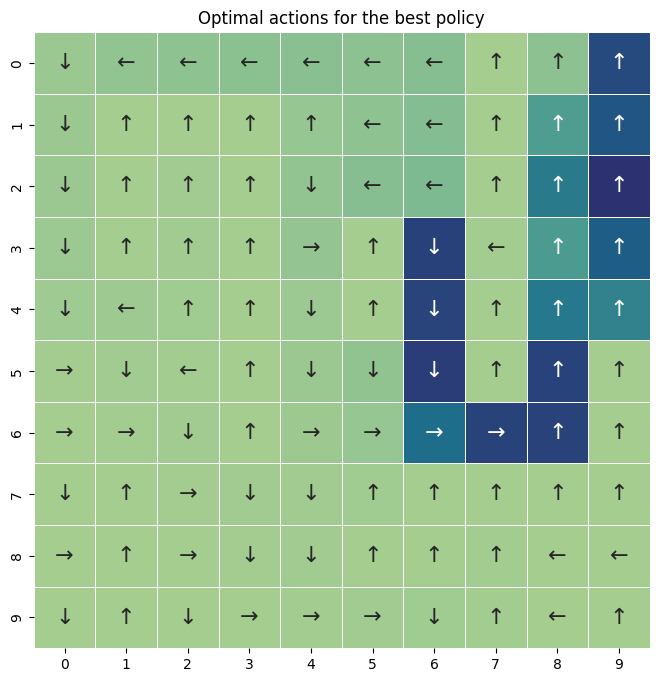

In [ ]:
max_indices = np.argmax(q_values, axis=1)
directions = {0: '↑', 1: '↓', 2: '←', 3: '→'}
direction_labels = np.vectorize(lambda x: directions[x])(max_indices)
direction_grid = direction_labels.reshape((10, 10))

plt.figure(figsize=(10, 8))
sns.heatmap(state_visits_2d, annot=direction_grid, fmt='',cmap="crest",
            cbar=False, linewidths=.5, square=True, annot_kws={'size': 16})
plt.title('Optimal actions for the best policy')
plt.show()

**Analysis 1:**


*   The best choice of hyperparameters for the above config are (alpha=1.0, gamma=1.0, epsilon=0.001).
*   The agent  starts with reward = -200 and then converges to approx 0 rewards after 50 episodes

*   Initially the agent took 100 steps to reach the goal but then after 100 episodes it converges to 20 steps but then has minor fluctuations from thereon


---

**Analysis 2:**


*   The agent takes its 1st step down from the start state (3,6) majority of the times

*   But due to a stochasticity of 1, it tends to explore nearby states as well

* With epsilon greedy, the agent just sticks to one goal state (8,7) and majority of the times choses actions that tend to visit the 3rd goal state (8,7)

*   With Wind, the agent moves towards the right state with a 40% probab and that is clearly visible from (4,8)->(4,9) and (1,8)->(1,9) and in many other states where the right state is not obstructed and it chooses the rightmost path from (4,8) due to the effect of wind


*   Since there is a restart state at (3,7), the Agent initially again restarts exploration from its start state and then over time finds another way which avoids the restart state and that is the reason for minor fluctuations in the steps graph
---



### (1) Configuration id <<4>>

#### Configuration Parameters
Learning algorithm = SARSA

Wind = True

Start State = (3,6)

Value of $p$ = 1

Exploration strategy = softmax

Train the agent

In [ ]:
rewards, steps, state_visits, q_values = sarsa(env_s2_p2, 1.0, 1.0, temperature=0.1, wind=True)

1. Plot reward curves (during the training phase with the best hyperparameters).

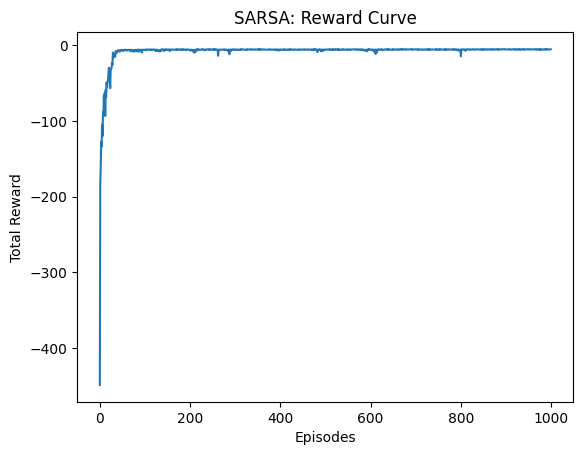

In [ ]:
plt.plot(rewards)
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.title('SARSA: Reward Curve')
plt.show()

2. Plot the number of steps to reach the goal in each episode (during the training phase with the best hyperparameters).

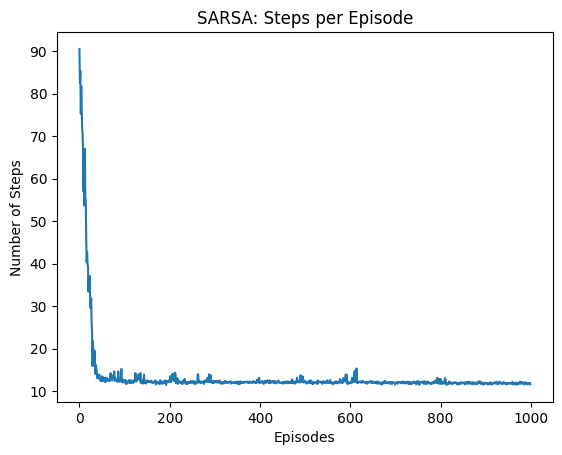

In [ ]:
plt.plot(steps)
plt.xlabel('Episodes')
plt.ylabel('Number of Steps')
plt.title('SARSA: Steps per Episode')
plt.show()

3. Heatmap of the grid with state visit counts, i.e., the number of times each state was visited throughout the training phase.

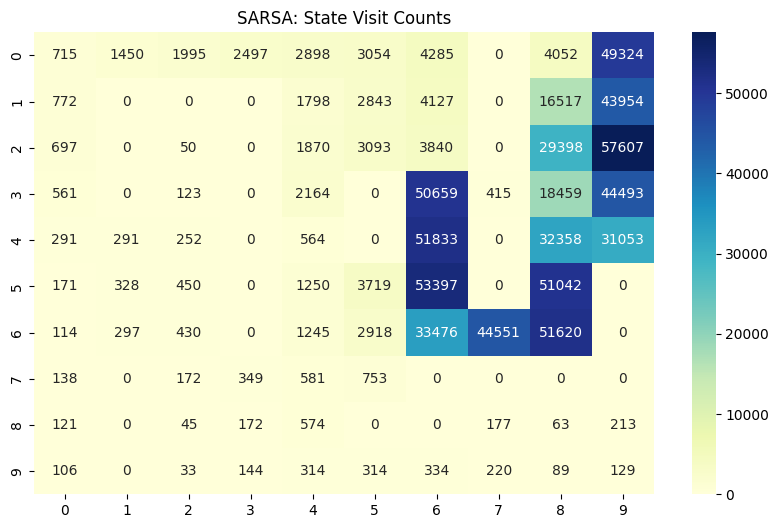

In [ ]:
state_visits_2d = state_visits.reshape((num_rows, num_rows))
plt.figure(figsize=(10, 6))
sns.heatmap(state_visits_2d, annot=True, fmt=".0f",
            cmap="YlGnBu",  cbar=True)
plt.title('SARSA: State Visit Counts')
plt.show()

4. Heatmap of the grid with Q values after training is complete, and optimal actions for the best policy.

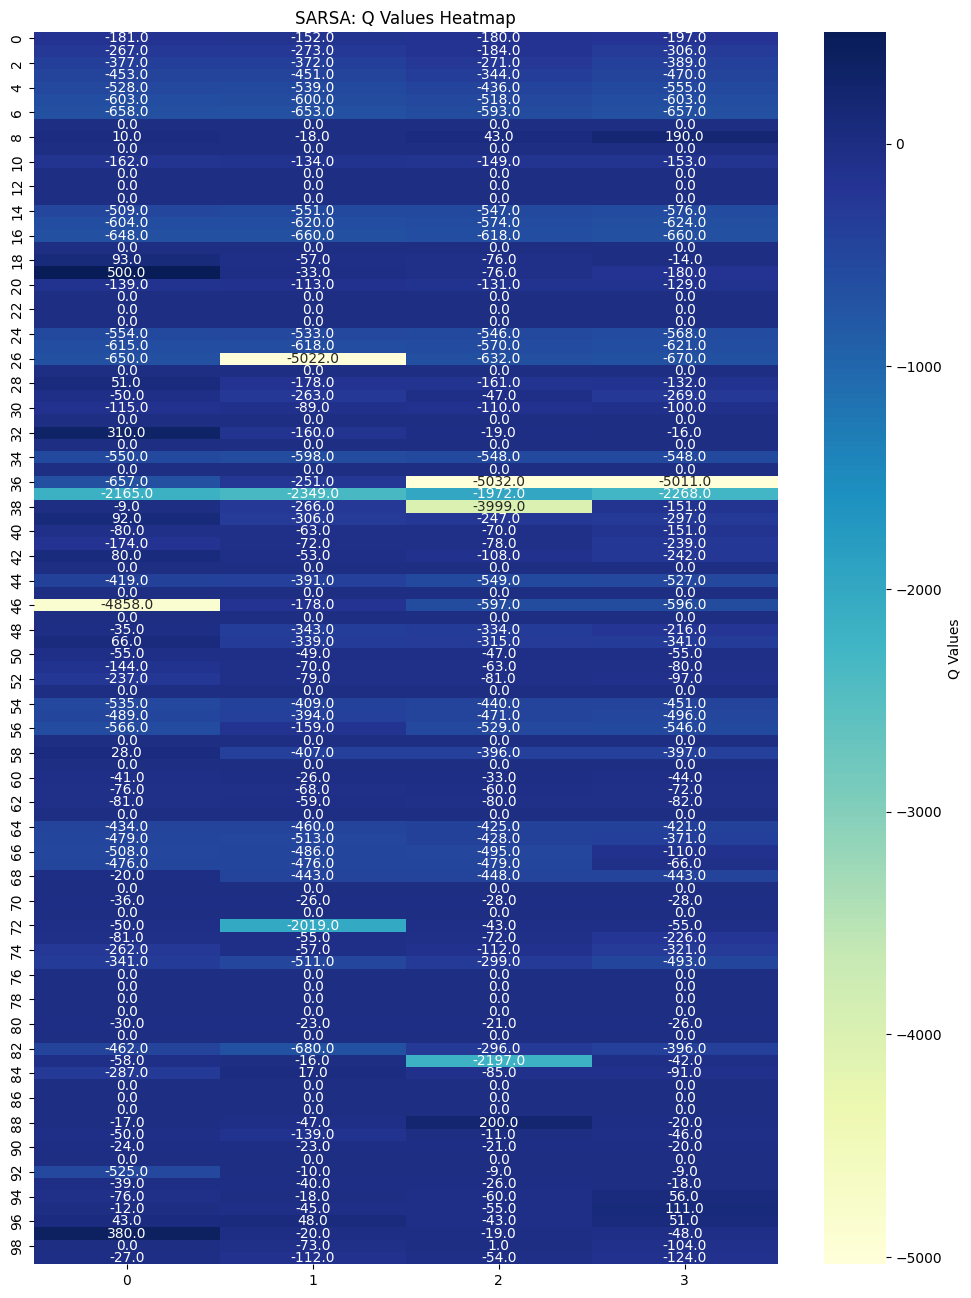

In [ ]:
plt.figure(figsize=(12, 16))
sns.heatmap(q_values, annot=True, fmt=".1f", cmap="YlGnBu", cbar_kws={'label': 'Q Values'})
plt.title('SARSA: Q Values Heatmap')
plt.show()

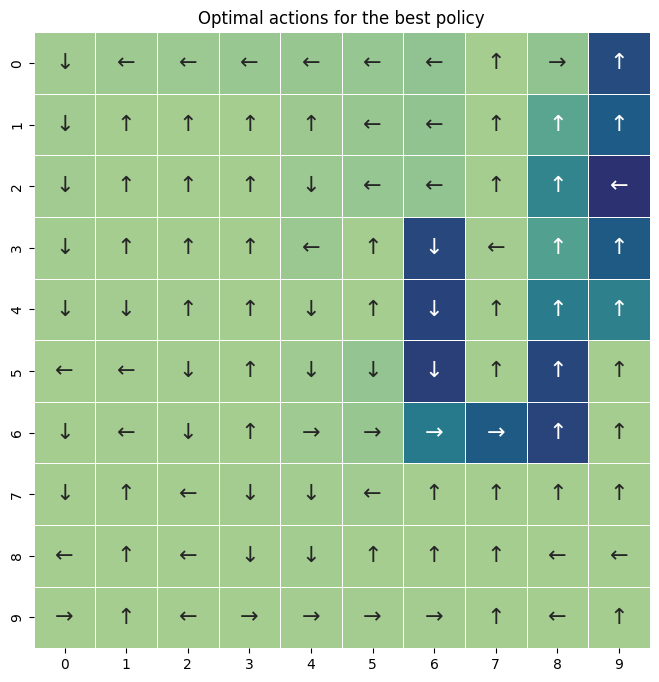

In [ ]:
max_indices = np.argmax(q_values, axis=1)
directions = {0: '↑', 1: '↓', 2: '←', 3: '→'}
direction_labels = np.vectorize(lambda x: directions[x])(max_indices)
direction_grid = direction_labels.reshape((10, 10))

plt.figure(figsize=(10, 8))
sns.heatmap(state_visits_2d, annot=direction_grid, fmt='',cmap="crest",
            cbar=False, linewidths=.5, square=True, annot_kws={'size': 16})
plt.title('Optimal actions for the best policy')
plt.show()

**Analysis 1:**


*   The best choice of hyperparameters for the above config are (alpha=1.0, gamma=1.0, temperature=0.1).
*   The agent  starts with reward =close to -100 and then converges to approx 0 rewards after 50 episodes

*   Here the agent only took max 90 steps to reach the goal but then after 100 episodes it converges to 20 steps but then has minor fluctuations from thereon


*   Since 100 is the max steps, here there has not been 1 episode where the Agent has not reached the Goal State





---

**Analysis 2:**


*   The agent takes its 1st step down from the start state (3,6) majority of the times

*   But due to a stochasticity of 1, it tends to explore nearby states as well

* With softmax too, the agent just sticks to one goal state (8,7) and majority of the times choses actions that tend to visit the 3rd goal state (8,7)

*   With Wind, the agent moves towards the right state with a 40% probab and that is clearly visible from (4,2)->(5,2) and (4,3)->(5,3) and in many other states where the right state is not obstructed


*   Since there is a restart state at (3,7), the Agent initially again restarts exploration from its start state and then over time finds another way which avoids the restart state and that is the reason for minor fluctuations in the steps graph

---



### (1) Configuration id <<5>>

#### Configuration Parameters
Learning algorithm = SARSA

Wind = False

Start State = (0,4)

Value of $p$ = 1

Exploration strategy = epsilon-greedy

Train the agent

In [ ]:
rewards, steps, state_visits, q_values = sarsa(env_s1_p2, 1.0, 1.0, epsilon=0.001, wind=False)

1. Plot reward curves (during the training phase with the best hyperparameters).

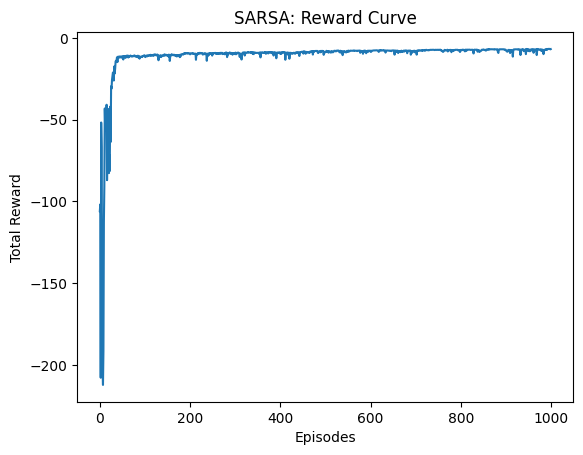

In [ ]:
plt.plot(rewards)
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.title('SARSA: Reward Curve')
plt.show()

2. Plot the number of steps to reach the goal in each episode (during the training phase with the best hyperparameters).

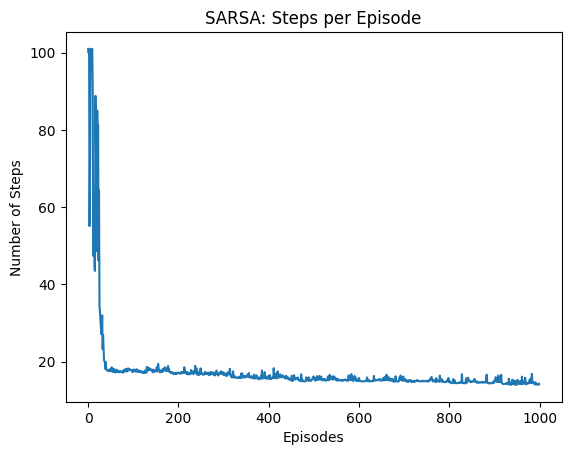

In [ ]:
plt.plot(steps)
plt.xlabel('Episodes')
plt.ylabel('Number of Steps')
plt.title('SARSA: Steps per Episode')
plt.show()

3. Heatmap of the grid with state visit counts, i.e., the number of times each state was visited throughout the training phase.

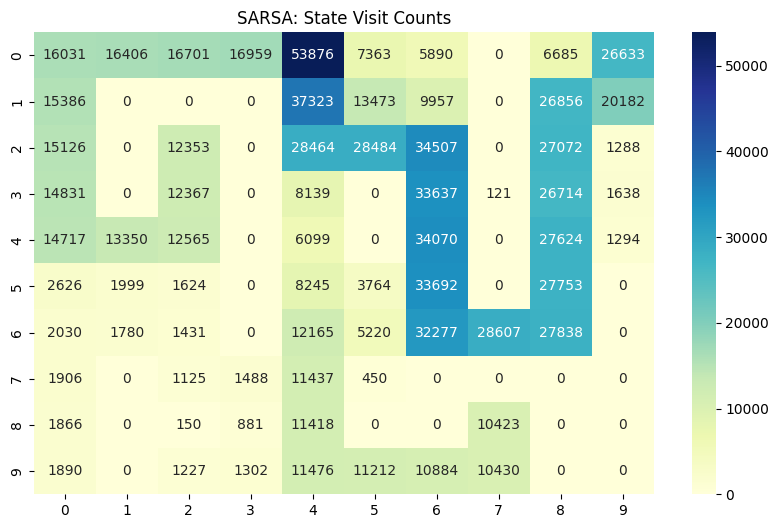

In [ ]:
state_visits_2d = state_visits.reshape((num_rows, num_rows))
plt.figure(figsize=(10, 6))
sns.heatmap(state_visits_2d, annot=True, fmt=".0f",
            cmap="YlGnBu",  cbar=True)
plt.title('SARSA: State Visit Counts')
plt.show()

4. Heatmap of the grid with Q values after training is complete, and optimal actions for the best policy.

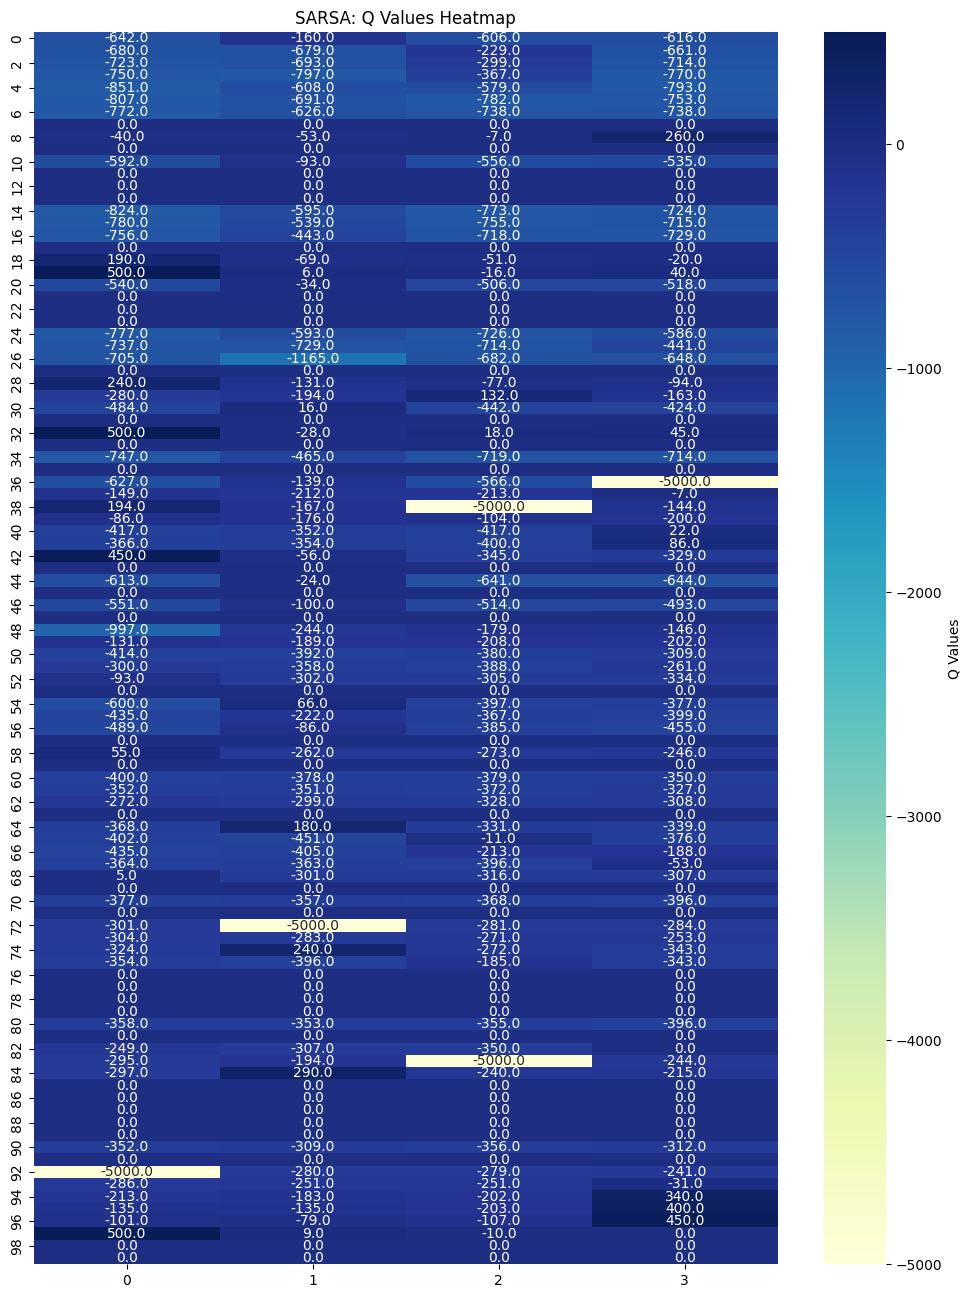

In [ ]:
plt.figure(figsize=(12, 16))
sns.heatmap(q_values, annot=True, fmt=".1f", cmap="YlGnBu", cbar_kws={'label': 'Q Values'})
plt.title('SARSA: Q Values Heatmap')
plt.show()

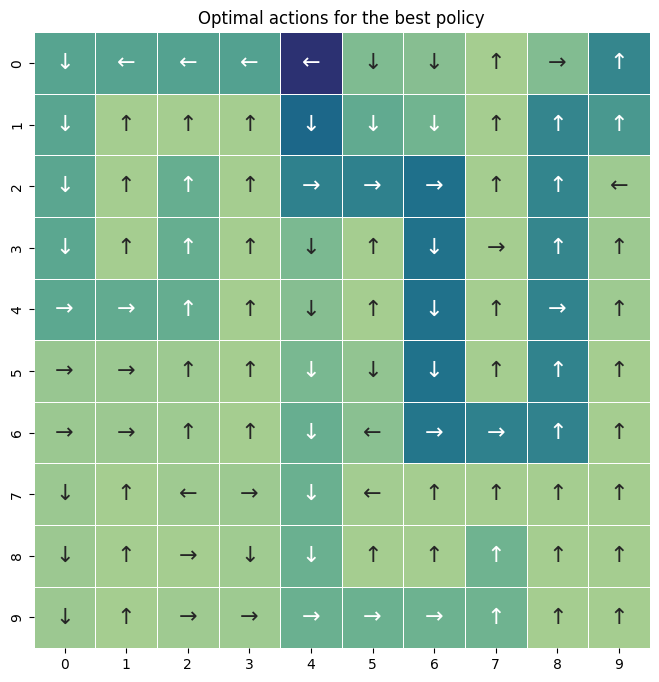

In [ ]:
max_indices = np.argmax(q_values, axis=1)
directions = {0: '↑', 1: '↓', 2: '←', 3: '→'}
direction_labels = np.vectorize(lambda x: directions[x])(max_indices)
direction_grid = direction_labels.reshape((10, 10))

plt.figure(figsize=(10, 8))
sns.heatmap(state_visits_2d, annot=direction_grid, fmt='',cmap="crest",
            cbar=False, linewidths=.5, square=True, annot_kws={'size': 16})
plt.title('Optimal actions for the best policy')
plt.show()

**Analysis 1:**


*   The best choice of hyperparameters for the above config are (alpha=1.0, gamma=1.0, epsilon=0.001).
*   The agent  starts with reward close to -100 and fluctuates a lot before converging to 0 after 50 episodes

*   Here the agent initally took 100 steps to reach the goal but has a huge fluctuation before converging to 20 steps after 50 episodes but then has minor fluctuations from thereon
---

**Analysis 2:**


*   The agent takes its 1st step down from the start state (0,4) majority of the times and left sometimes

*   But due to a stochasticity of 1, it tends to explore nearby states as well

* With epsilon greedy, the agent tends visit all 3 goal states with second goal state (0,9) being the most visited one, followed by the 1st goal state (2,2) and then (8,7)

*   Compared to the (config id #1), we can observe that without the wind, the goal preference of the agent changes from (2,2)->(0,9)


*   Since there is a restart state at (3,7), the Agent initially again restarts exploration from its start state and then over time finds another way which avoids the restart state and that is the reason for minor fluctuations in the steps graph

---



### (1) Configuration id << 6 >>

#### Configuration Parameters
Learning algorithm = SARSA

Wind = False

Start State = (0,4)

Value of $p$ = 1

Exploration strategy = softmax

Train the agent

In [ ]:
rewards, steps, state_visits, q_values = sarsa(env_s1_p2, 1.0, 0.9, temperature=0.1, wind=False)

1. Plot reward curves (during the training phase with the best hyperparameters).

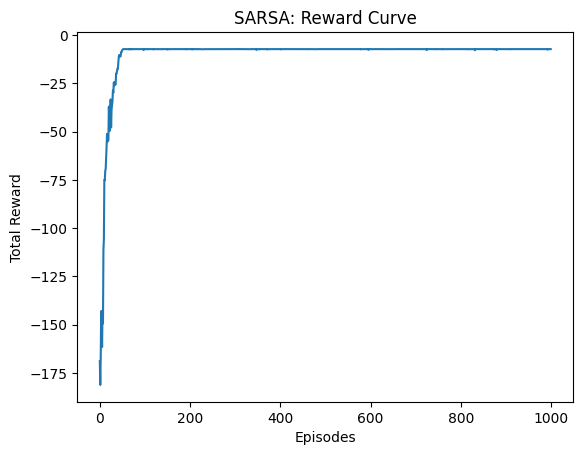

In [ ]:
plt.plot(rewards)
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.title('SARSA: Reward Curve')
plt.show()

2. Plot the number of steps to reach the goal in each episode (during the training phase with the best hyperparameters).

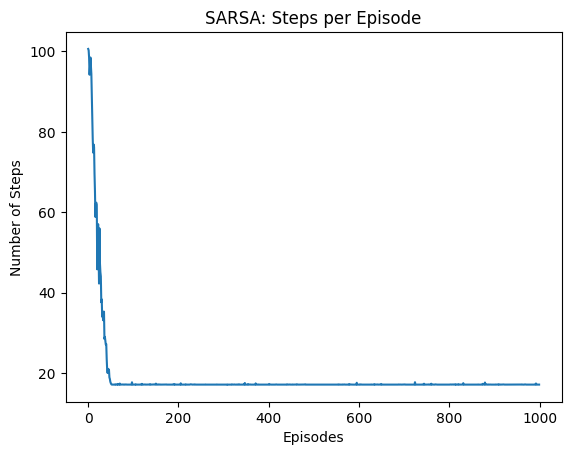

In [ ]:
plt.plot(steps)
plt.xlabel('Episodes')
plt.ylabel('Number of Steps')
plt.title('SARSA: Steps per Episode')
plt.show()

3. Heatmap of the grid with state visit counts, i.e., the number of times each state was visited throughout the training phase.

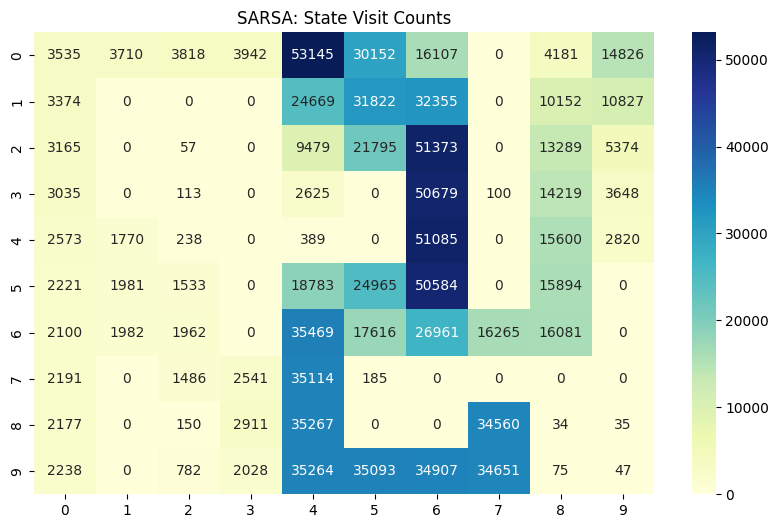

In [ ]:
state_visits_2d = state_visits.reshape((num_rows, num_rows))
plt.figure(figsize=(10, 6))
sns.heatmap(state_visits_2d, annot=True, fmt=".0f",
            cmap="YlGnBu",  cbar=True)
plt.title('SARSA: State Visit Counts')
plt.show()

4. Heatmap of the grid with Q values after training is complete, and optimal actions for the best policy.

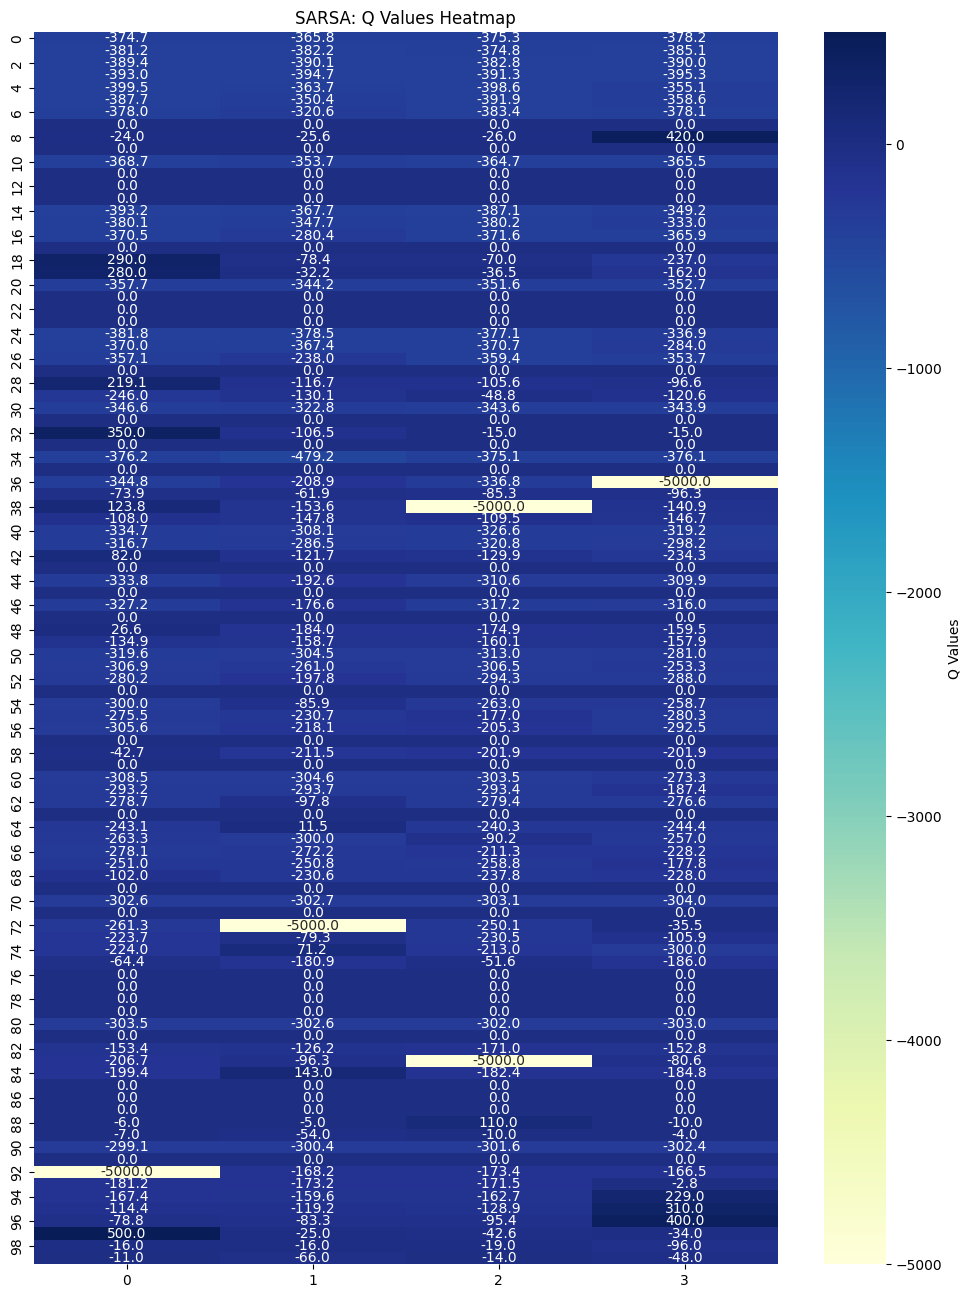

In [ ]:
plt.figure(figsize=(12, 16))
sns.heatmap(q_values, annot=True, fmt=".1f", cmap="YlGnBu", cbar_kws={'label': 'Q Values'})
plt.title('SARSA: Q Values Heatmap')
plt.show()

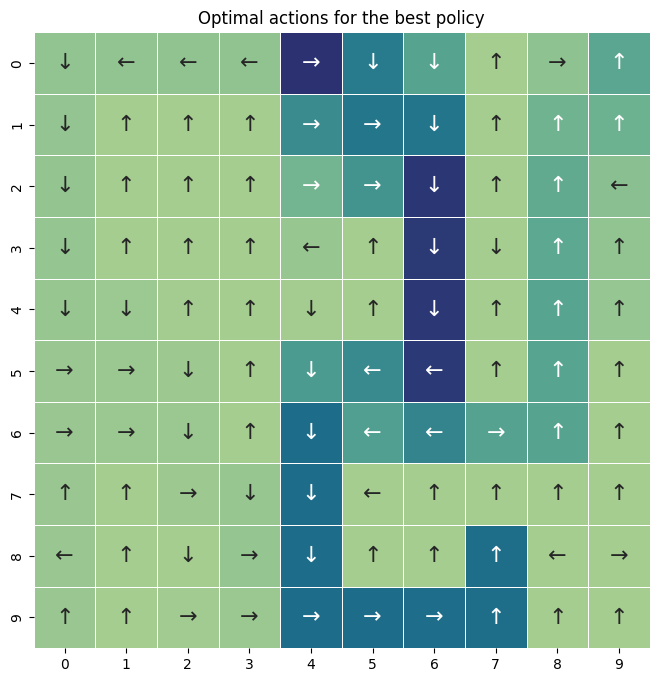

In [ ]:
max_indices = np.argmax(q_values, axis=1)
directions = {0: '↑', 1: '↓', 2: '←', 3: '→'}
direction_labels = np.vectorize(lambda x: directions[x])(max_indices)
direction_grid = direction_labels.reshape((10, 10))

plt.figure(figsize=(10, 8))
sns.heatmap(state_visits_2d, annot=direction_grid, fmt='',cmap="crest",
            cbar=False, linewidths=.5, square=True, annot_kws={'size': 16})
plt.title('Optimal actions for the best policy')
plt.show()

**Analysis 1:**


*   The best choice of hyperparameters for the above config are (alpha=1.0, gamma=0.9, temperature=0.1).
*   The agent  starts with reward close to -175 and converging to 0 after 50 episodes with close to no fluctuations

*   Here the agent initally took 100 steps to reach the goal and then converges to 20 steps after 50 episodes
---

**Analysis 2:**


*   The agent takes its 1st step right from the start state (0,4) majority of the times and left sometimes

*   But due to a stochasticity of 1, it tends to explore nearby states as well

* With softmax, third goal state (8,7) is the the most visited one, followed by the 2nd goal state (0,9)

*   Compared to the (config id #2), we can observe that without the wind, the goal preference of the agent changes from (2,2)->(8,7) and here the exploration is also much higher


*   Since the path to the 3rd goal state (8,7) has no bad states and the restart states are visited very less, there are very few fluctuations in the the reward and steps graph

---



### (1) Configuration id << 7 >>

#### Configuration Parameters
Learning algorithm = SARSA

Wind = False

Start State = (3,6)

Value of $p$ = 1

Exploration strategy = epsilon-greedy

Train the agent

In [ ]:
rewards, steps, state_visits, q_values = sarsa(env_s2_p2, 1.0, 0.7, epsilon=0.001, wind=False)

1. Plot reward curves (during the training phase with the best hyperparameters).

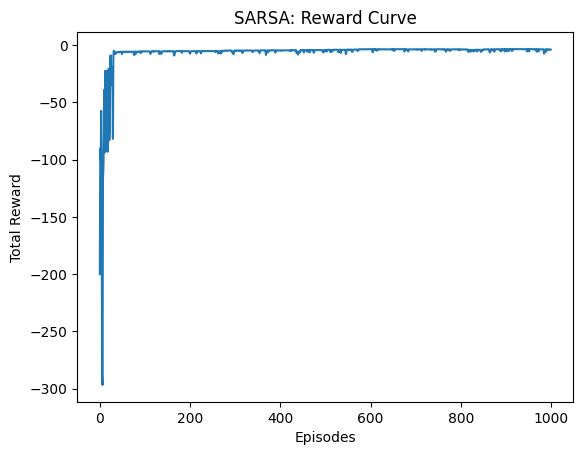

In [ ]:
plt.plot(rewards)
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.title('SARSA: Reward Curve')
plt.show()

2. Plot the number of steps to reach the goal in each episode (during the training phase with the best hyperparameters).

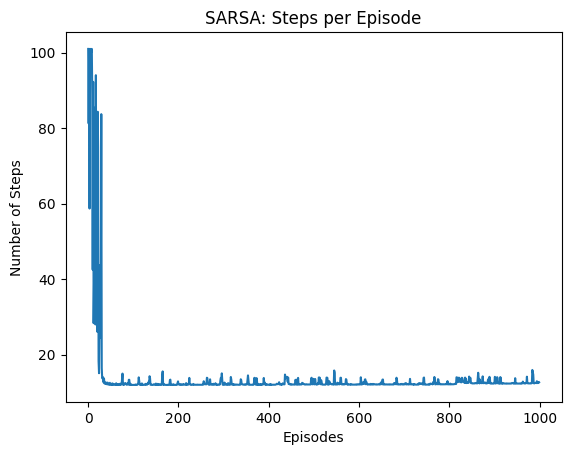

In [ ]:
plt.plot(steps)
plt.xlabel('Episodes')
plt.ylabel('Number of Steps')
plt.title('SARSA: Steps per Episode')
plt.show()

3. Heatmap of the grid with state visit counts, i.e., the number of times each state was visited throughout the training phase.

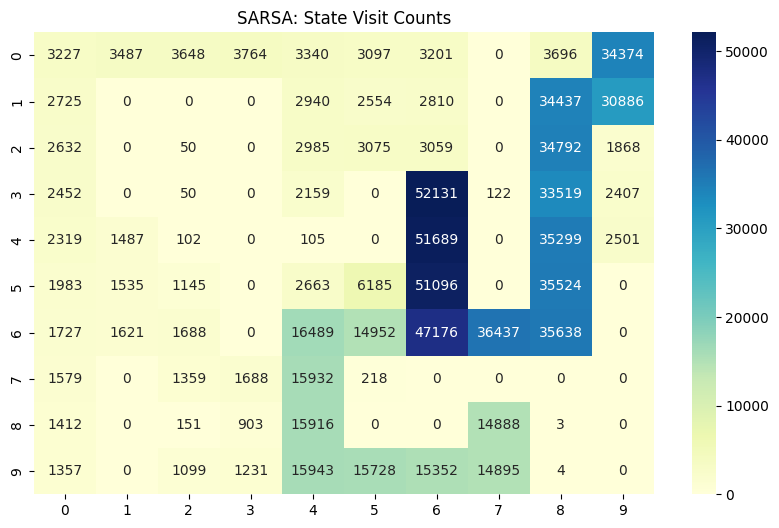

In [ ]:
state_visits_2d = state_visits.reshape((num_rows, num_rows))
plt.figure(figsize=(10, 6))
sns.heatmap(state_visits_2d, annot=True, fmt=".0f",
            cmap="YlGnBu",  cbar=True)
plt.title('SARSA: State Visit Counts')
plt.show()

4. Heatmap of the grid with Q values after training is complete, and optimal actions for the best policy.

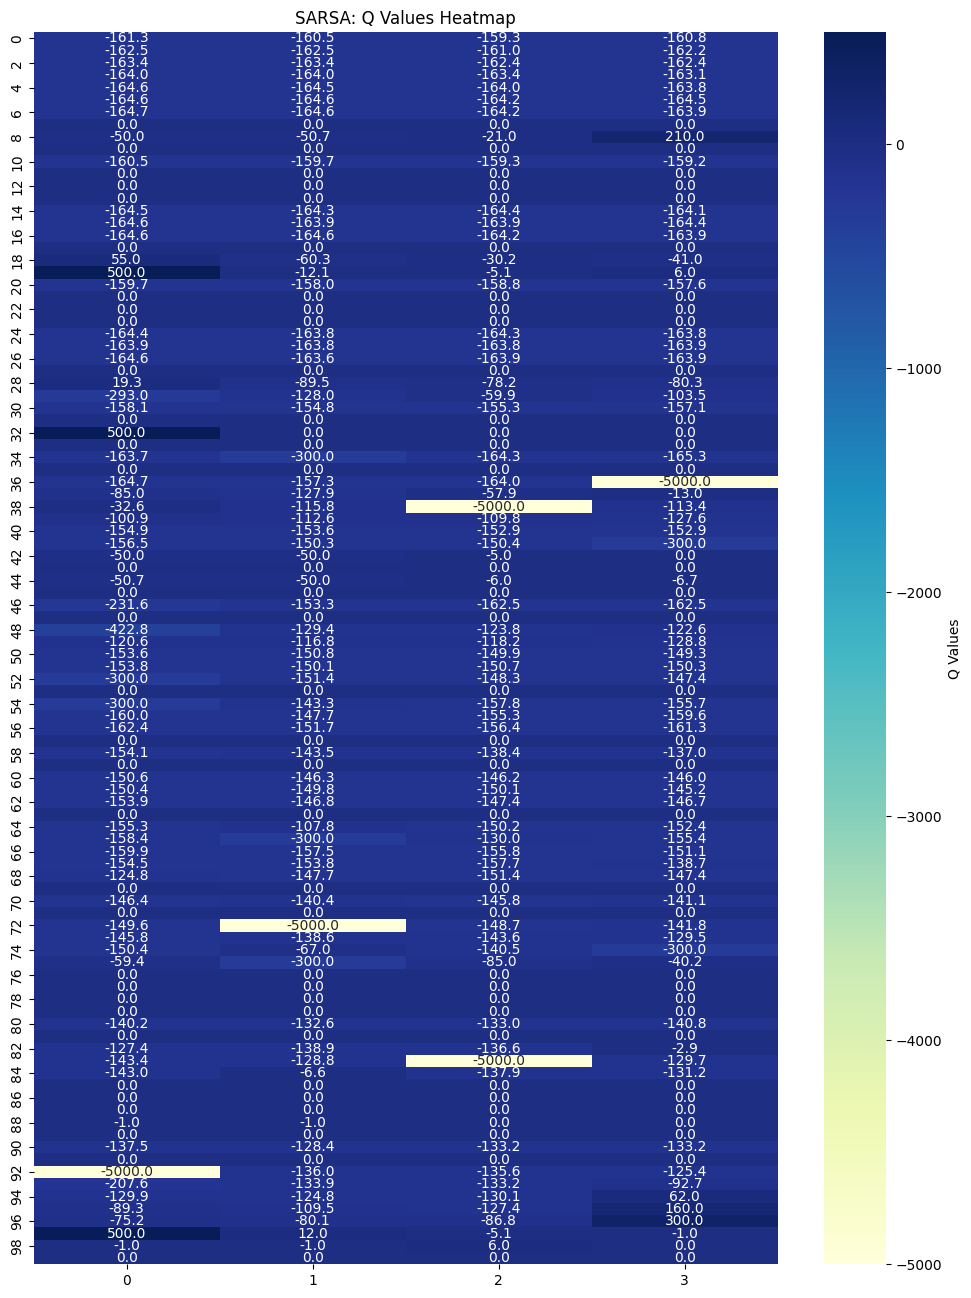

In [ ]:
plt.figure(figsize=(12, 16))
sns.heatmap(q_values, annot=True, fmt=".1f", cmap="YlGnBu", cbar_kws={'label': 'Q Values'})
plt.title('SARSA: Q Values Heatmap')
plt.show()

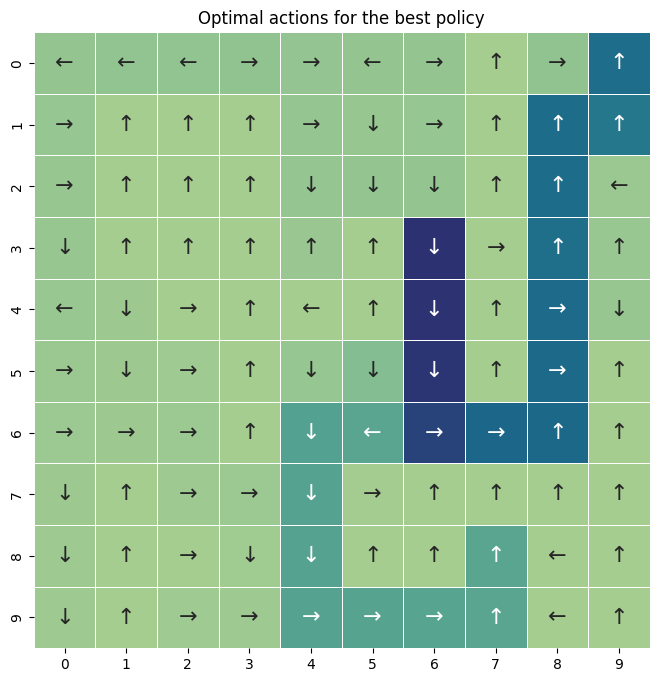

In [ ]:
max_indices = np.argmax(q_values, axis=1)
directions = {0: '↑', 1: '↓', 2: '←', 3: '→'}
direction_labels = np.vectorize(lambda x: directions[x])(max_indices)
direction_grid = direction_labels.reshape((10, 10))

plt.figure(figsize=(10, 8))
sns.heatmap(state_visits_2d, annot=direction_grid, fmt='',cmap="crest",
            cbar=False, linewidths=.5, square=True, annot_kws={'size': 16})
plt.title('Optimal actions for the best policy')
plt.show()

**Analysis 1:**


*   The best choice of hyperparameters for the above config are (alpha=1.0, gamma=0.9, epsilon=0.001).
*   The agent  starts with reward close to -300 and converging to 0 after 50 episodes with a lot of fluctuations

*   Here the agent initally took 100 steps to reach the goal and then converges to 20 steps after 20 episodes with a lot of fluctuations
---

**Analysis 2:**


*   The agent takes its 1st step down from the start state (3,6) majority of the times and left sometimes

*   But due to a stochasticity of 1, it tends to explore nearby states as well

* With epsilon greedy, 2nd goal state (0,9) is the the most visited one, followed by the 3rd goal state (8,7)

*   Compared to the (config id #3), we can observe that without the wind, the goal preference of the agent stays the same (0,9), but at (6,6) the agent tends to explore the 3rd goal state path sometimes


*   Since the path to the 2nd goal state (0,9) has a bad state and a restart state , there are a lot of fluctuations in the the reward and steps graph

---



### (1) Configuration id << 8 >>

#### Configuration Parameters
Learning algorithm = SARSA

Wind = False

Start State = (3,6)

Value of $p$ = 1

Exploration strategy = softmax

Train the agent

In [ ]:
rewards, steps, state_visits, q_values = sarsa(env_s2_p2, 1.0, 0.8, temperature=0.1, wind=False)

1. Plot reward curves (during the training phase with the best hyperparameters).

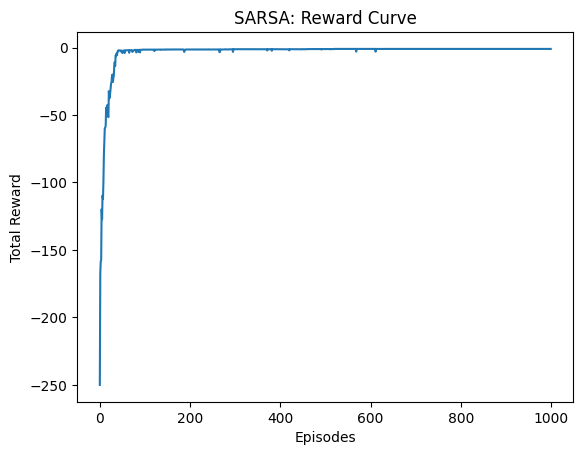

In [ ]:
plt.plot(rewards)
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.title('SARSA: Reward Curve')
plt.show()

2. Plot the number of steps to reach the goal in each episode (during the training phase with the best hyperparameters).

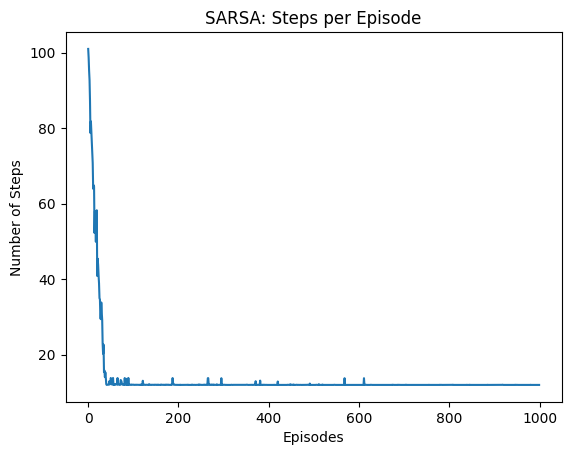

In [ ]:
plt.plot(steps)
plt.xlabel('Episodes')
plt.ylabel('Number of Steps')
plt.title('SARSA: Steps per Episode')
plt.show()

3. Heatmap of the grid with state visit counts, i.e., the number of times each state was visited throughout the training phase.

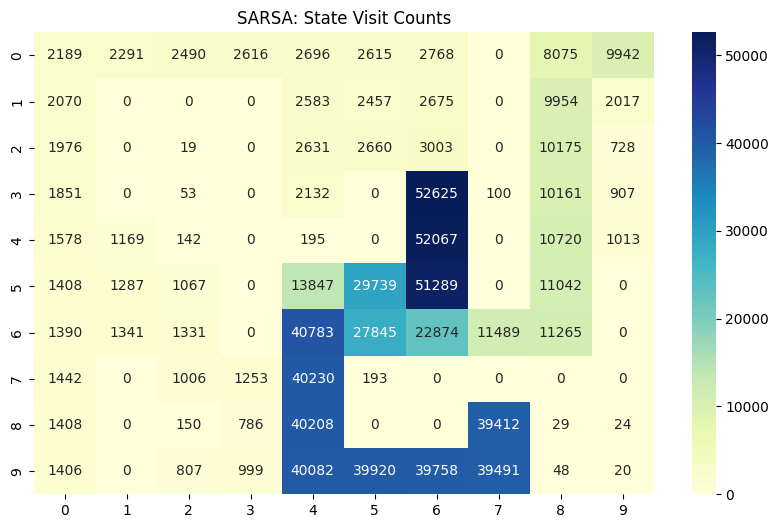

In [ ]:
state_visits_2d = state_visits.reshape((num_rows, num_rows))
plt.figure(figsize=(10, 6))
sns.heatmap(state_visits_2d, annot=True, fmt=".0f",
            cmap="YlGnBu",  cbar=True)
plt.title('SARSA: State Visit Counts')
plt.show()

4. Heatmap of the grid with Q values after training is complete, and optimal actions for the best policy.

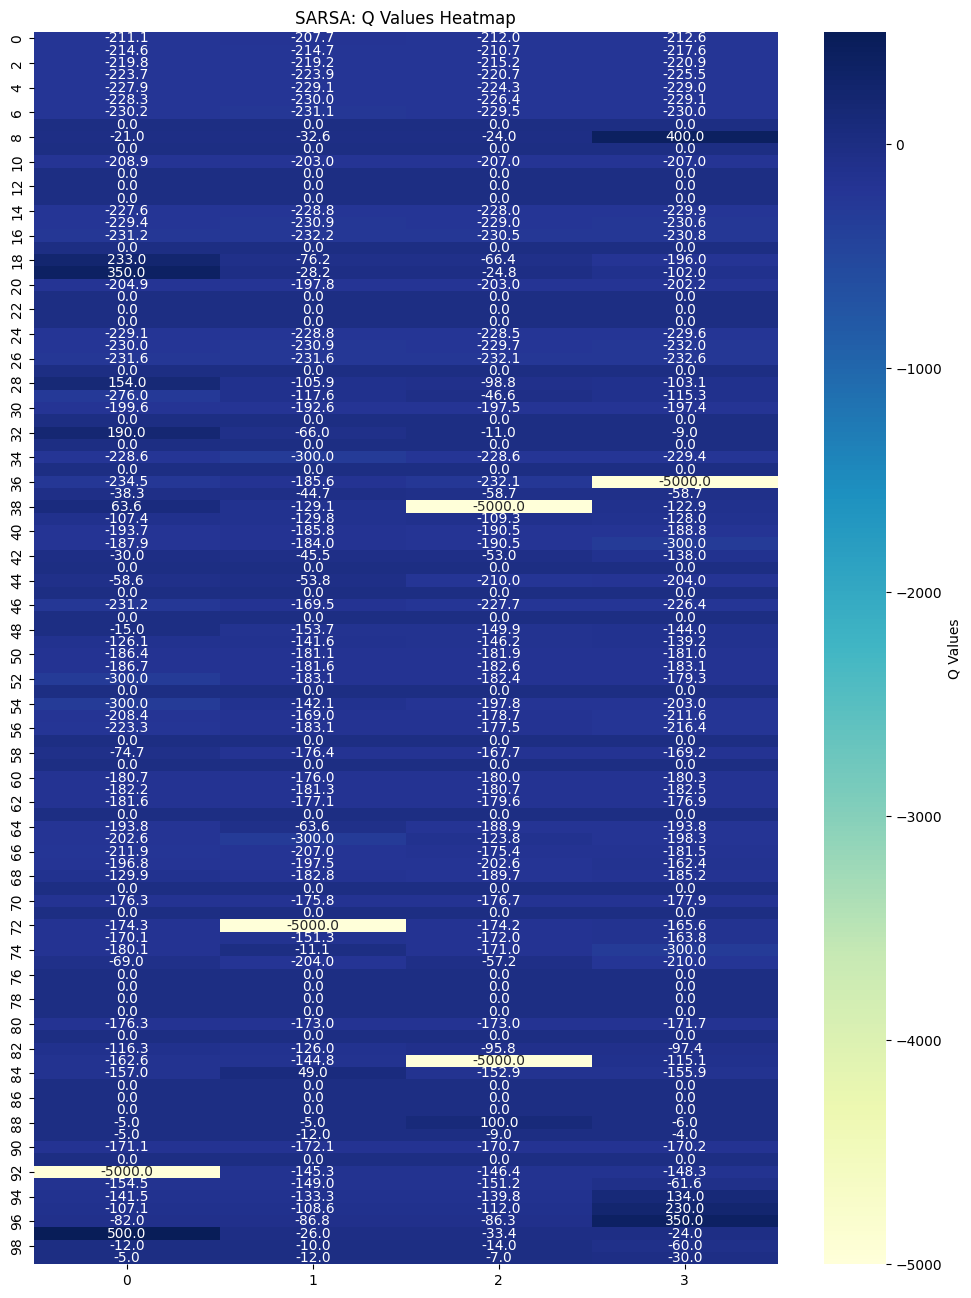

In [ ]:
plt.figure(figsize=(12, 16))
sns.heatmap(q_values, annot=True, fmt=".1f", cmap="YlGnBu", cbar_kws={'label': 'Q Values'})
plt.title('SARSA: Q Values Heatmap')
plt.show()

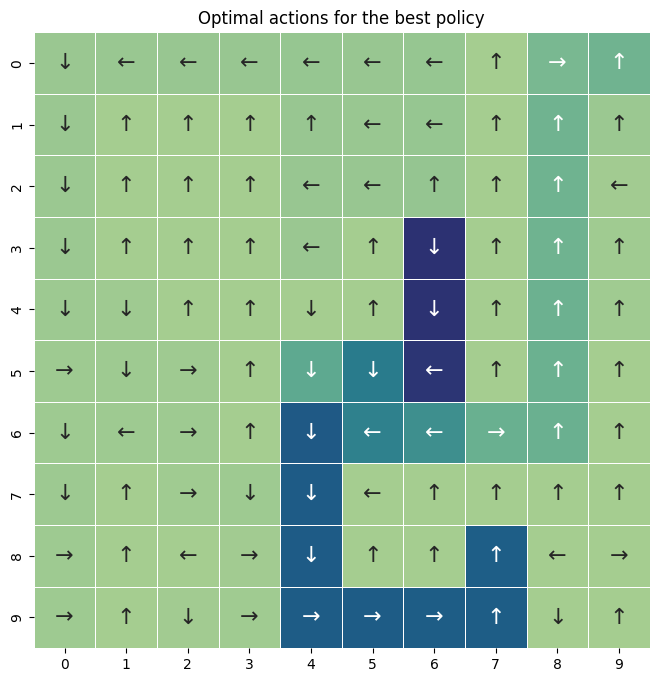

In [ ]:
max_indices = np.argmax(q_values, axis=1)
directions = {0: '↑', 1: '↓', 2: '←', 3: '→'}
direction_labels = np.vectorize(lambda x: directions[x])(max_indices)
direction_grid = direction_labels.reshape((10, 10))

plt.figure(figsize=(10, 8))
sns.heatmap(state_visits_2d, annot=direction_grid, fmt='',cmap="crest",
            cbar=False, linewidths=.5, square=True, annot_kws={'size': 16})
plt.title('Optimal actions for the best policy')
plt.show()

**Analysis 1:**


*   The best choice of hyperparameters for the above config are (alpha=1.0, gamma=0.8, softmax=0.1).
*   The agent  starts with reward close to -250 and converging to 0 after 50 episodes with minimal fluctutations

*   Here the agent initally took 100 steps to reach the goal and then converges to 20 steps after 20 episodes with a minimal fluctuations
---

**Analysis 2:**


*   The agent takes its 1st step down from the start state (3,6) majority of the times and left sometimes

*   But due to a stochasticity of 1, it tends to explore nearby states as well

* With softmax, 3rd goal state (8,7) is the the most visited one compared to the 2nd goal state in (config #7) which uses epsilon greedy

*   Compared to the (config id #4), we can observe that without the wind, the goal preference of the agent changes from (0,9) to (8,7)

*   Since the path to the 3rd goal state (8,7) has no bad states and the restart states are visited very less, there are very few fluctuations in the the reward and steps graph


---



### (1) Configuration id << 9 >>

#### Configuration Parameters
Learning algorithm = Q-LEARNING

Wind = False

Start State = (0,4)

Value of $p$ = 1

Exploration strategy = epsilon-greedy

Train the agent

In [ ]:
rewards, steps, state_visits, q_values = q_learning(env_s1_p2, 1.0, 0.7, epsilon=0.01, wind=False)

1. Plot reward curves (during the training phase with the best hyperparameters).

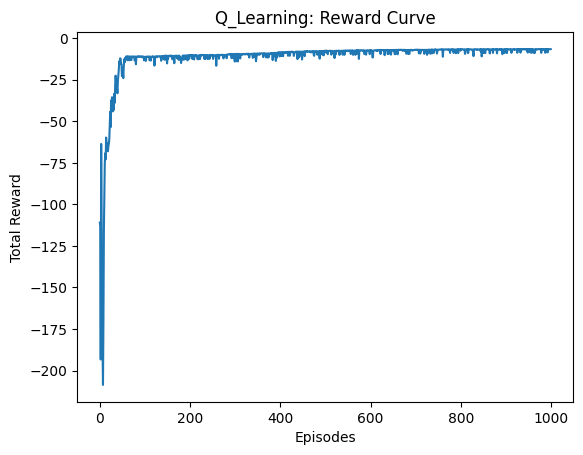

In [ ]:
plt.plot(rewards)
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.title('Q_Learning: Reward Curve')
plt.show()

2. Plot the number of steps to reach the goal in each episode (during the training phase with the best hyperparameters).

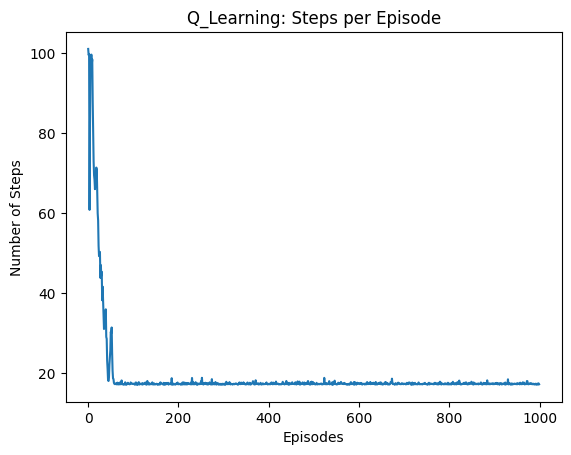

In [ ]:
plt.plot(steps)
plt.xlabel('Episodes')
plt.ylabel('Number of Steps')
plt.title('Q_Learning: Steps per Episode')
plt.show()

3. Heatmap of the grid with state visit counts, i.e., the number of times each state was visited throughout the training phase.

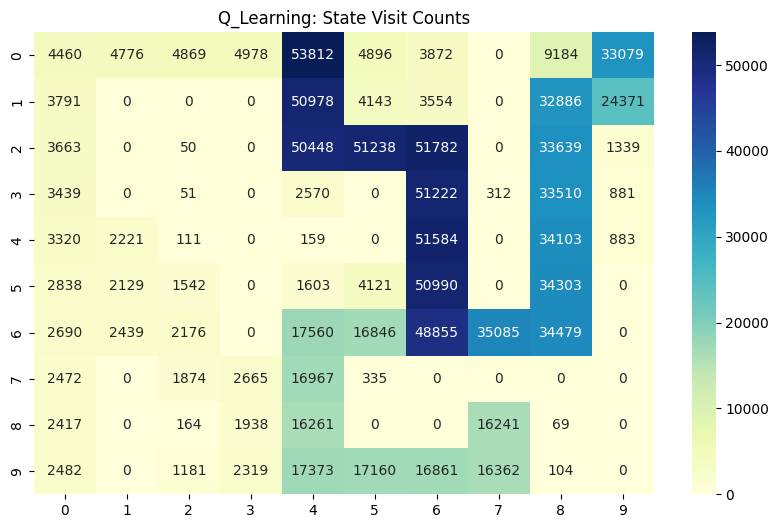

In [ ]:
state_visits_2d = state_visits.reshape((num_rows, num_rows))
plt.figure(figsize=(10, 6))
sns.heatmap(state_visits_2d, annot=True, fmt=".0f",
            cmap="YlGnBu",  cbar=True)
plt.title('Q_Learning: State Visit Counts')
plt.show()

4. Heatmap of the grid with Q values after training is complete, and optimal actions for the best policy.

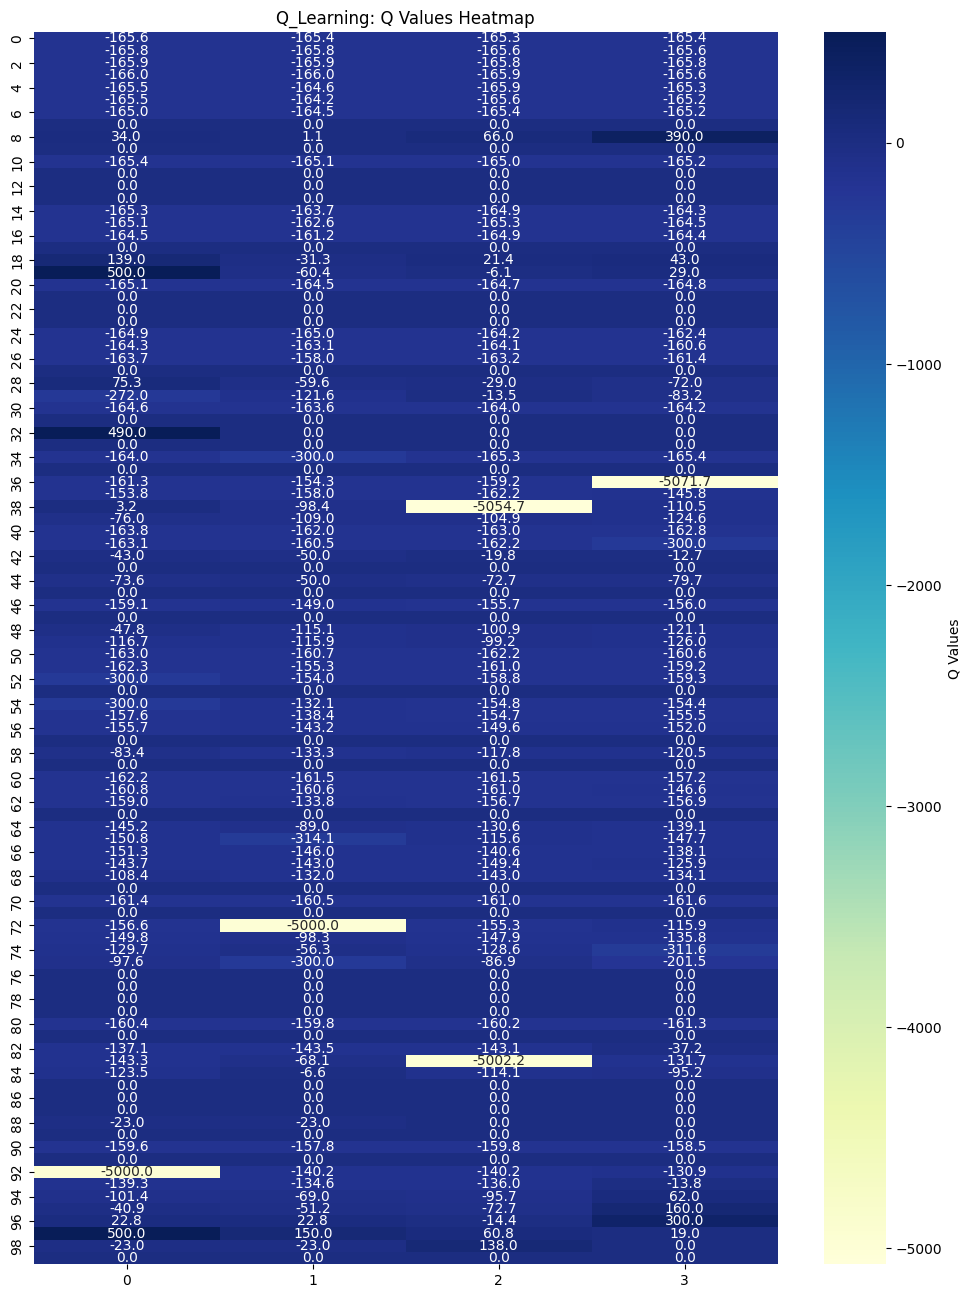

In [ ]:
plt.figure(figsize=(12, 16))
sns.heatmap(q_values, annot=True, fmt=".1f", cmap="YlGnBu", cbar_kws={'label': 'Q Values'})
plt.title('Q_Learning: Q Values Heatmap')
plt.show()

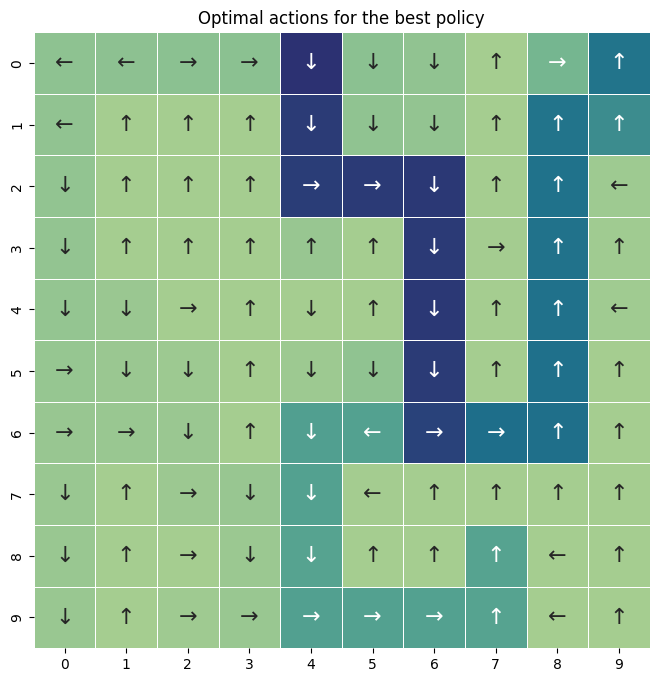

In [ ]:
max_indices = np.argmax(q_values, axis=1)
directions = {0: '↑', 1: '↓', 2: '←', 3: '→'}
direction_labels = np.vectorize(lambda x: directions[x])(max_indices)
direction_grid = direction_labels.reshape((10, 10))

plt.figure(figsize=(10, 8))
sns.heatmap(state_visits_2d, annot=direction_grid, fmt='',cmap="crest",
            cbar=False, linewidths=.5, square=True, annot_kws={'size': 16})
plt.title('Optimal actions for the best policy')
plt.show()

**Analysis 1:**


*   The best choice of hyperparameters for the above config are (alpha=1.0, gamma=0.7, epsilon=0.01).
*   The agent  starts with reward close to -200 and keep increasing to 0 with fluctuations

*   Here the agent initally took 100 steps to reach the goal and then converges to 20 steps after 50 episodes after a lot of fluctuations
---

**Analysis 2:**


*   The agent takes its 1st step down from the start state (0,4) majority of the times and left sometimes

*   But due to a stochasticity of 1, it tends to explore nearby states as well

* With epsilon greedy, 2nd goal state (0,9) is the the most visited one, whereas the 3rd goal state is also visited a lot of times


* Since the path to the 2nd goal state (0,9) has a bad state and a restart state , there are a lot of fluctuations in the the reward and steps graph

---



### (1) Configuration id << 10 >>

#### Configuration Parameters
Learning algorithm = Q Learning

Wind = False

Start State = (0,4)

Value of $p$ = 1

Exploration strategy = softmax

Train the agent

In [ ]:
rewards, steps, state_visits, q_values = q_learning(env_s1_p2, 1.0, 0.9, temperature=0.1, wind=False)

1. Plot reward curves (during the training phase with the best hyperparameters).

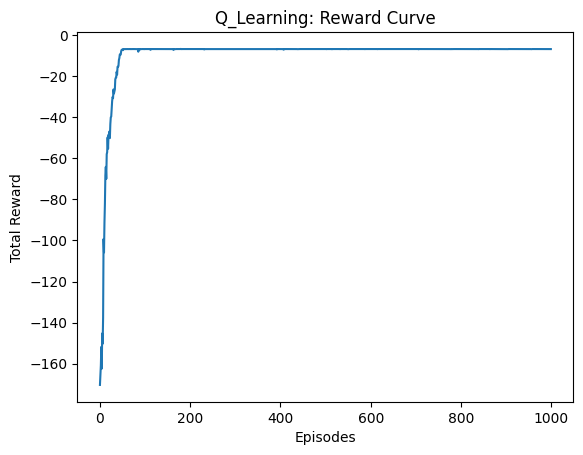

In [ ]:
plt.plot(rewards)
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.title('Q_Learning: Reward Curve')
plt.show()

2. Plot the number of steps to reach the goal in each episode (during the training phase with the best hyperparameters).

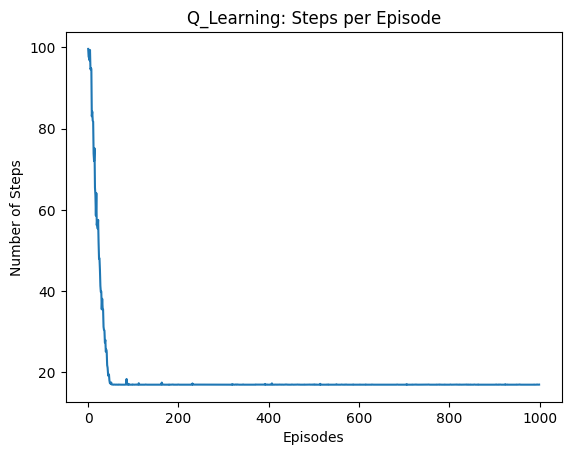

In [ ]:
plt.plot(steps)
plt.xlabel('Episodes')
plt.ylabel('Number of Steps')
plt.title('Q_Learning: Steps per Episode')
plt.show()

3. Heatmap of the grid with state visit counts, i.e., the number of times each state was visited throughout the training phase.

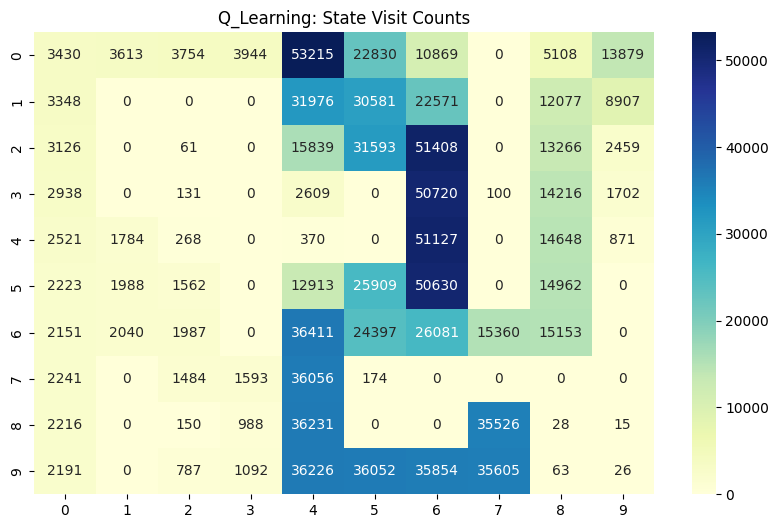

In [ ]:
state_visits_2d = state_visits.reshape((num_rows, num_rows))
plt.figure(figsize=(10, 6))
sns.heatmap(state_visits_2d, annot=True, fmt=".0f",
            cmap="YlGnBu",  cbar=True)
plt.title('Q_Learning: State Visit Counts')
plt.show()

4. Heatmap of the grid with Q values after training is complete, and optimal actions for the best policy.

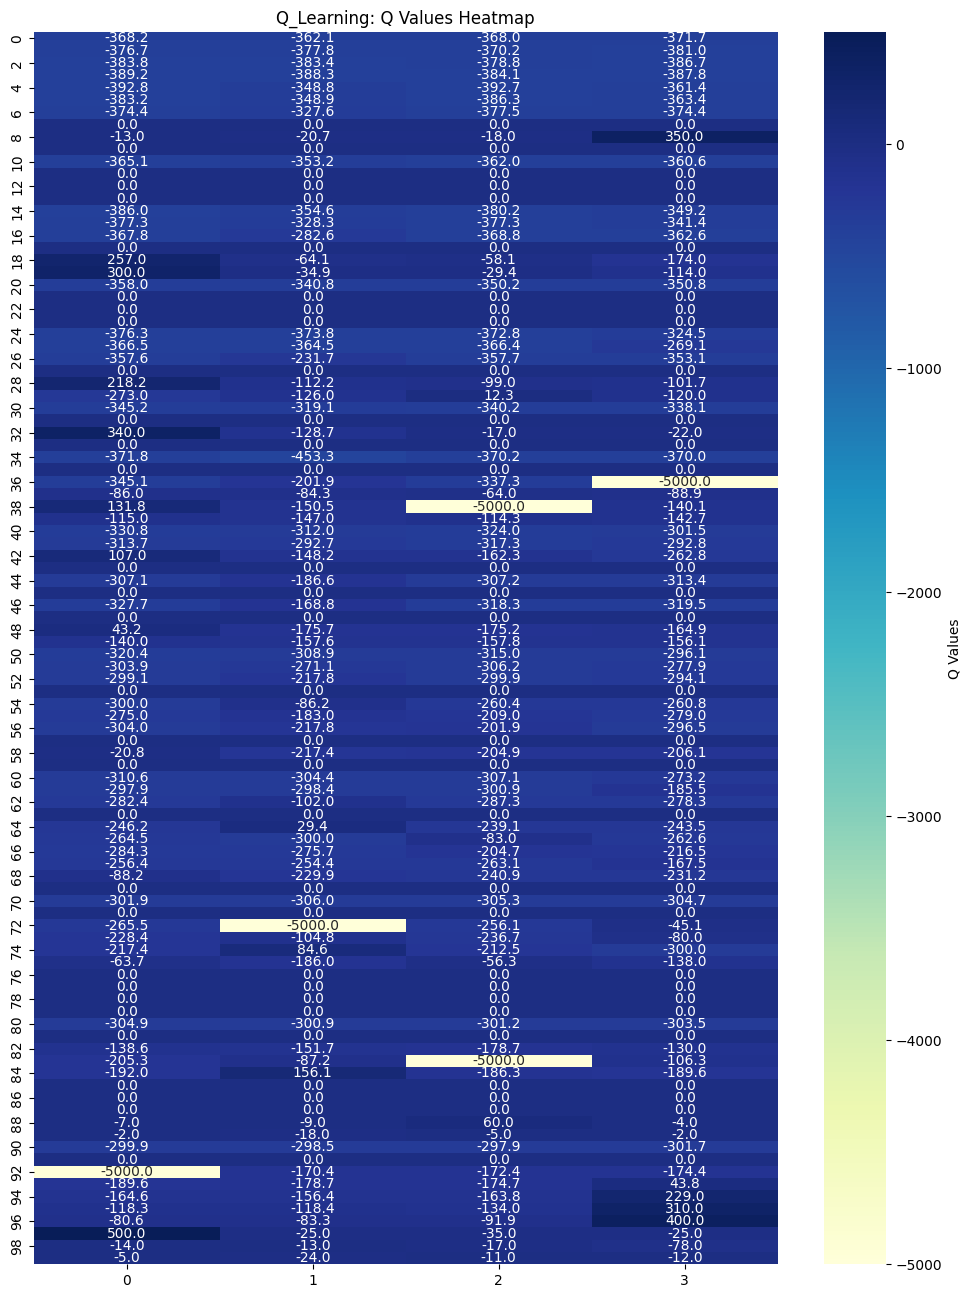

In [ ]:
plt.figure(figsize=(12, 16))
sns.heatmap(q_values, annot=True, fmt=".1f", cmap="YlGnBu", cbar_kws={'label': 'Q Values'})
plt.title('Q_Learning: Q Values Heatmap')
plt.show()

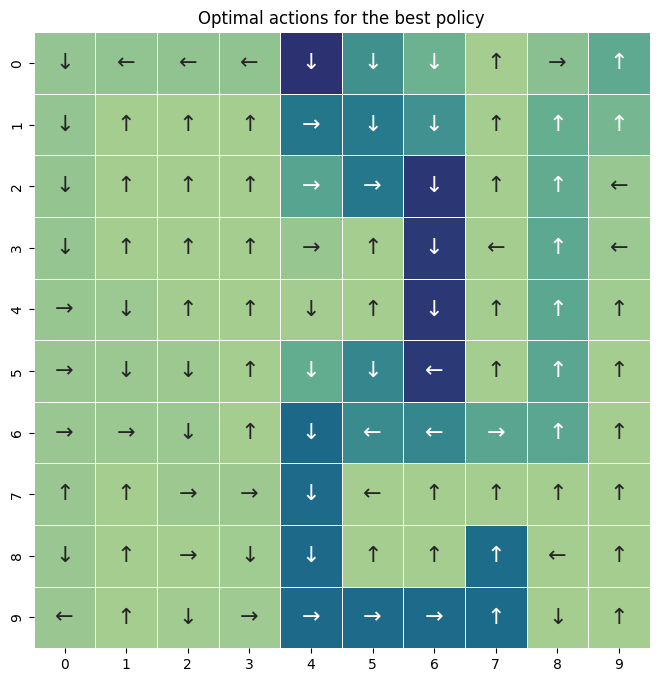

In [ ]:
max_indices = np.argmax(q_values, axis=1)
directions = {0: '↑', 1: '↓', 2: '←', 3: '→'}
direction_labels = np.vectorize(lambda x: directions[x])(max_indices)
direction_grid = direction_labels.reshape((10, 10))

plt.figure(figsize=(10, 8))
sns.heatmap(state_visits_2d, annot=direction_grid, fmt='',cmap="crest",
            cbar=False, linewidths=.5, square=True, annot_kws={'size': 16})
plt.title('Optimal actions for the best policy')
plt.show()

**Analysis 1:**


*   The best choice of hyperparameters for the above config are (alpha=1.0, gamma=0.9, temperature=0.1).
*   The agent  starts with reward close to -160 and converges to 0 with minimal fluctuations

*   Here the agent initally took 100 steps to reach the goal and then converges to 20 steps after 50 episodes with minimal fluctuations
---

**Analysis 2:**


*   The agent takes its 1st step down and right from the start state (0,4) majority of the times and left sometimes

*   But due to a stochasticity of 1, it tends to explore nearby states as well

* With softmax, 3rd goal state (8,7) is the the most visited one


*   Since the path to the 3rd goal state (8,7) has no bad states and the restart states are visited very less, there are very few fluctuations in the the reward and steps graph

---



### (1) Configuration id << 11 >>

#### Configuration Parameters
Learning algorithm = Q-LEARNING

Wind = False

Start State = (0,4)

Value of $p$ = 0.7

Exploration strategy = epsilon-greedy

Train the agent

In [ ]:
rewards, steps, state_visits, q_values = q_learning(env_s1_p1, 0.1, 1.0, epsilon=0.001, wind=False)

1. Plot reward curves (during the training phase with the best hyperparameters).

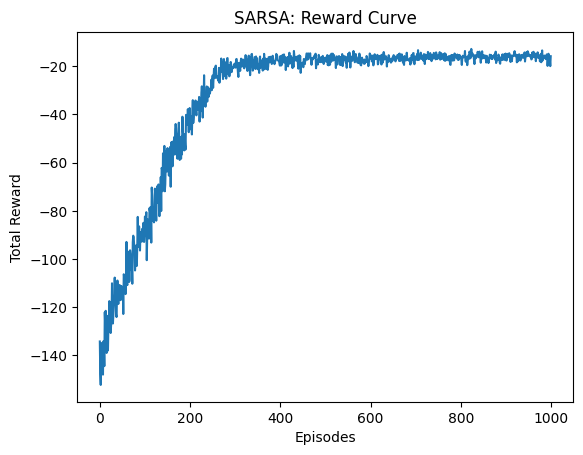

In [ ]:
plt.plot(rewards)
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.title('SARSA: Reward Curve')
plt.show()

2. Plot the number of steps to reach the goal in each episode (during the training phase with the best hyperparameters).

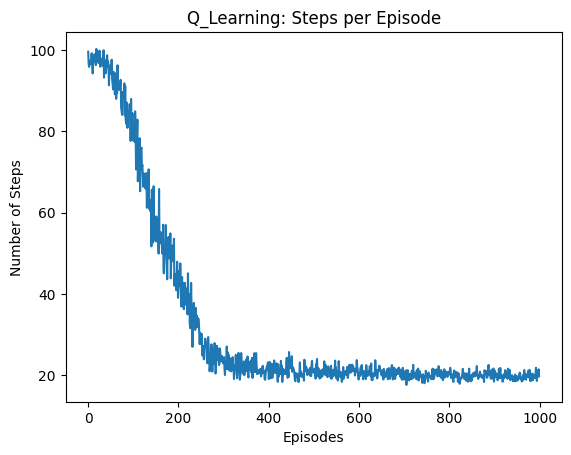

In [ ]:
plt.plot(steps)
plt.xlabel('Episodes')
plt.ylabel('Number of Steps')
plt.title('Q_Learning: Steps per Episode')
plt.show()

3. Heatmap of the grid with state visit counts, i.e., the number of times each state was visited throughout the training phase.

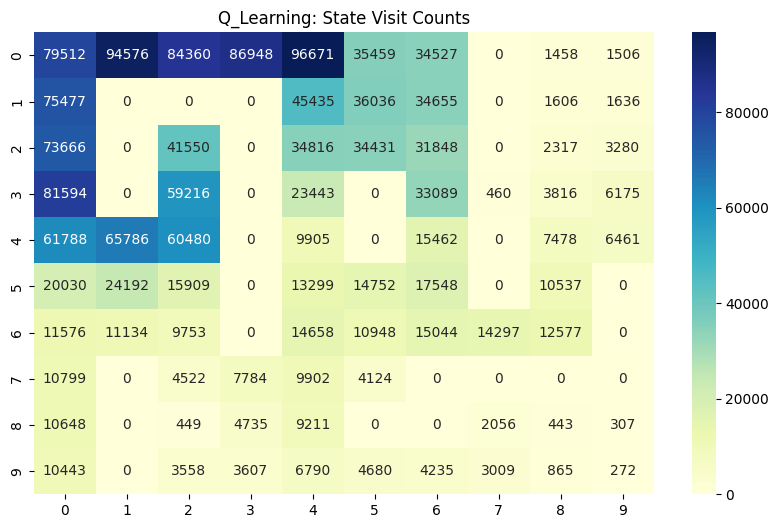

In [ ]:
state_visits_2d = state_visits.reshape((num_rows, num_rows))
plt.figure(figsize=(10, 6))
sns.heatmap(state_visits_2d, annot=True, fmt=".0f",
            cmap="YlGnBu",  cbar=True)
plt.title('Q_Learning: State Visit Counts')
plt.show()

4. Heatmap of the grid with Q values after training is complete, and optimal actions for the best policy.

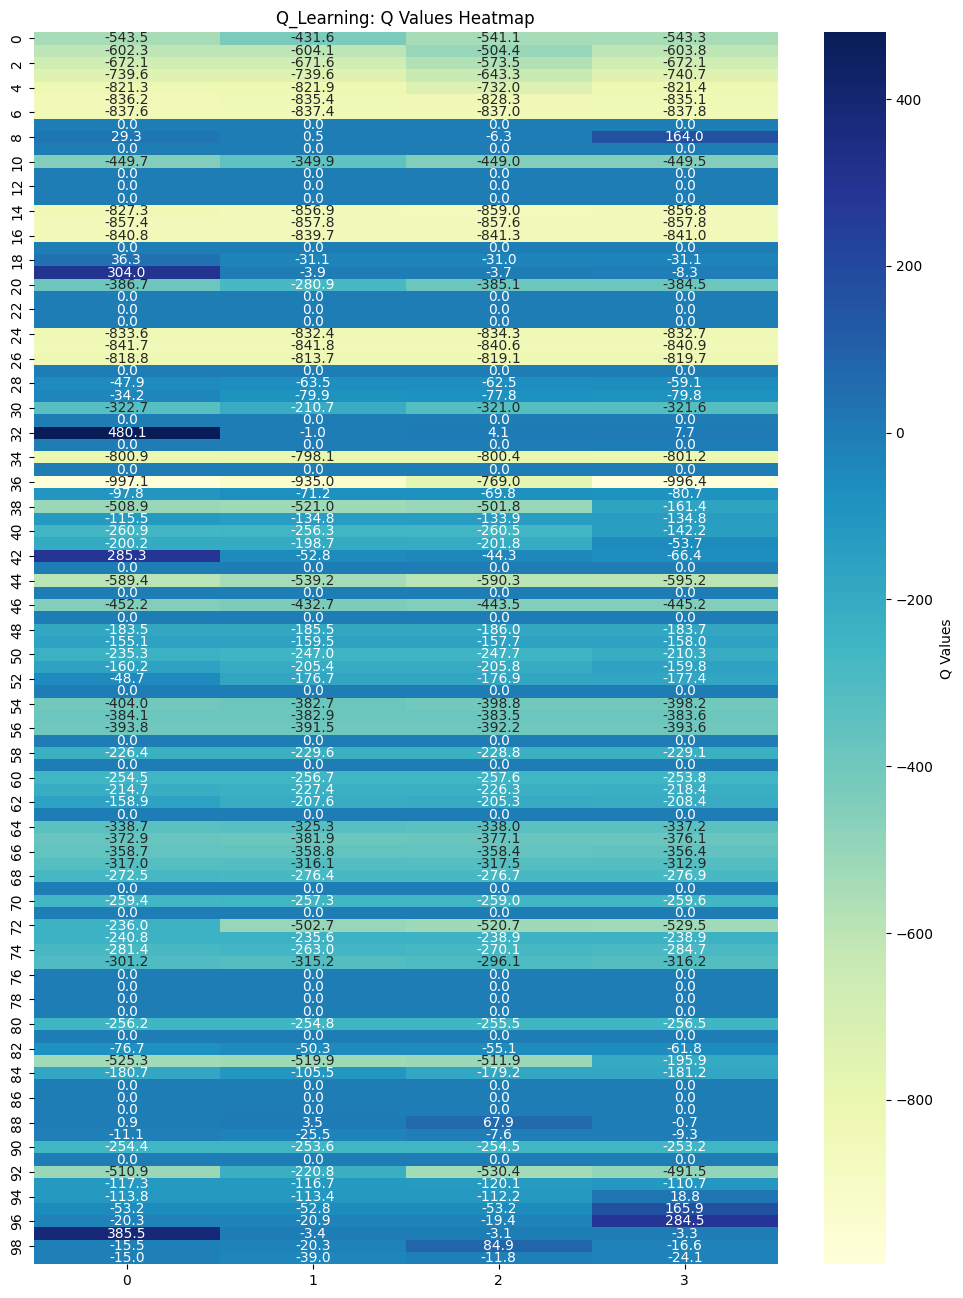

In [ ]:
plt.figure(figsize=(12, 16))
sns.heatmap(q_values, annot=True, fmt=".1f", cmap="YlGnBu", cbar_kws={'label': 'Q Values'})
plt.title('Q_Learning: Q Values Heatmap')
plt.show()

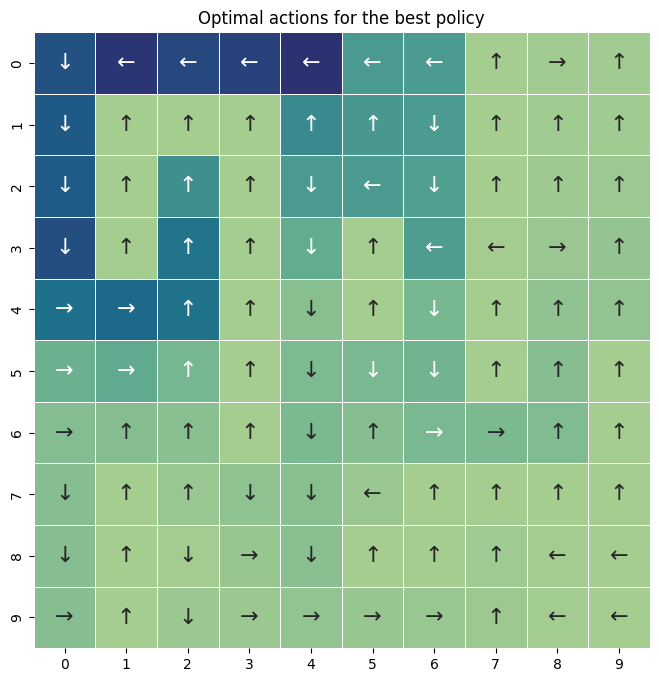

In [ ]:
max_indices = np.argmax(q_values, axis=1)
directions = {0: '↑', 1: '↓', 2: '←', 3: '→'}
direction_labels = np.vectorize(lambda x: directions[x])(max_indices)
direction_grid = direction_labels.reshape((10, 10))

plt.figure(figsize=(10, 8))
sns.heatmap(state_visits_2d, annot=direction_grid, fmt='',cmap="crest",
            cbar=False, linewidths=.5, square=True, annot_kws={'size': 16})
plt.title('Optimal actions for the best policy')
plt.show()

**Analysis 1:**


*   The best choice of hyperparameters for the above config are (alpha=0.1, gamma=1.0, epsilon=0.001).
*   The agent  starts with reward close to -140 and converges to -20 after 300 episodes with huge fluctuations

*   Here the agent initally took 100 steps to reach the goal and then converges to 20 steps after 250 episodes with huge fluctuations
---

**Analysis 2:**


*   The agent takes its 1st step left from the start state (0,4) majority of the times

* With epsilon greedy the optimal path is towards the 1st goal state


*   The reason for huge fluctuations in the rewards graph is due to stochasticity=0.7, the agents takes few steps towards the 2nd and 3rd goal by visiting the states in those paths but then moves very rarely towards the 2nd and 3rd goal states and fluctuations in the steps graph are due to the agent hitting the restart states while reaching the 2nd and 3rd goal states



---



### (1) Configuration id << 12 >>

#### Configuration Parameters
Learning algorithm = Q Learning

Wind = False

Start State = (0,4)

Value of $p$ = 0.7

Exploration strategy = softmax

Train the agent

In [ ]:
rewards, steps, state_visits, q_values = q_learning(env_s1_p1, 0.1, 1.0, temperature=0.01, wind=False)

1. Plot reward curves (during the training phase with the best hyperparameters).

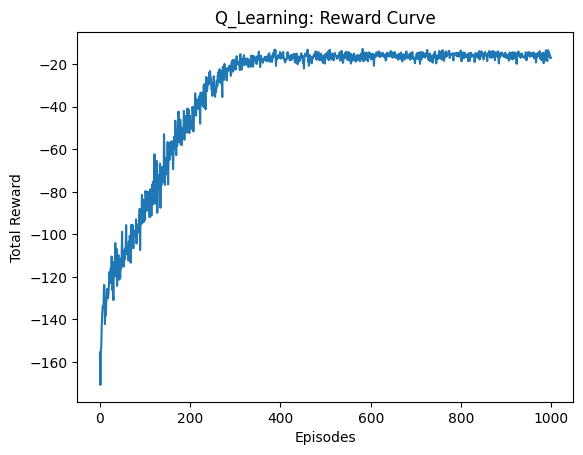

In [ ]:
plt.plot(rewards)
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.title('Q_Learning: Reward Curve')
plt.show()

2. Plot the number of steps to reach the goal in each episode (during the training phase with the best hyperparameters).

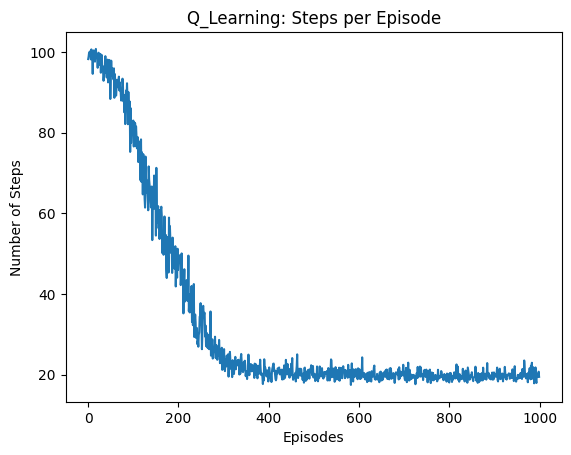

In [ ]:
plt.plot(steps)
plt.xlabel('Episodes')
plt.ylabel('Number of Steps')
plt.title('Q_Learning: Steps per Episode')
plt.show()

3. Heatmap of the grid with state visit counts, i.e., the number of times each state was visited throughout the training phase.

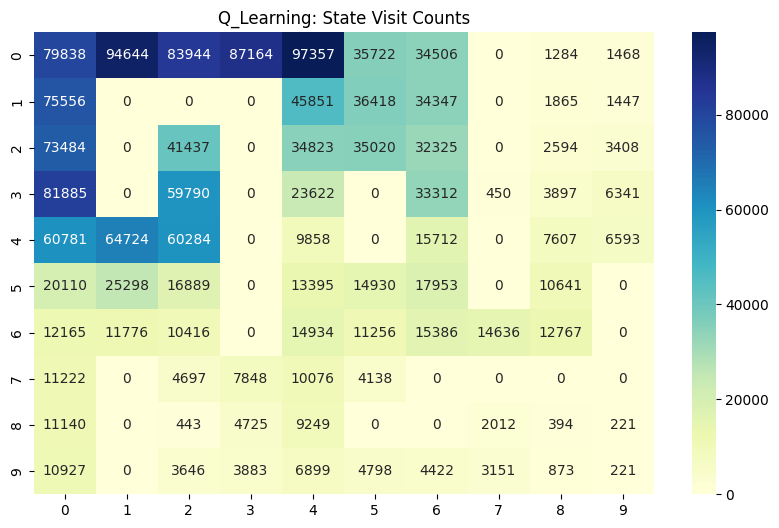

In [ ]:
state_visits_2d = state_visits.reshape((num_rows, num_rows))
plt.figure(figsize=(10, 6))
sns.heatmap(state_visits_2d, annot=True, fmt=".0f",
            cmap="YlGnBu",  cbar=True)
plt.title('Q_Learning: State Visit Counts')
plt.show()

4. Heatmap of the grid with Q values after training is complete, and optimal actions for the best policy.

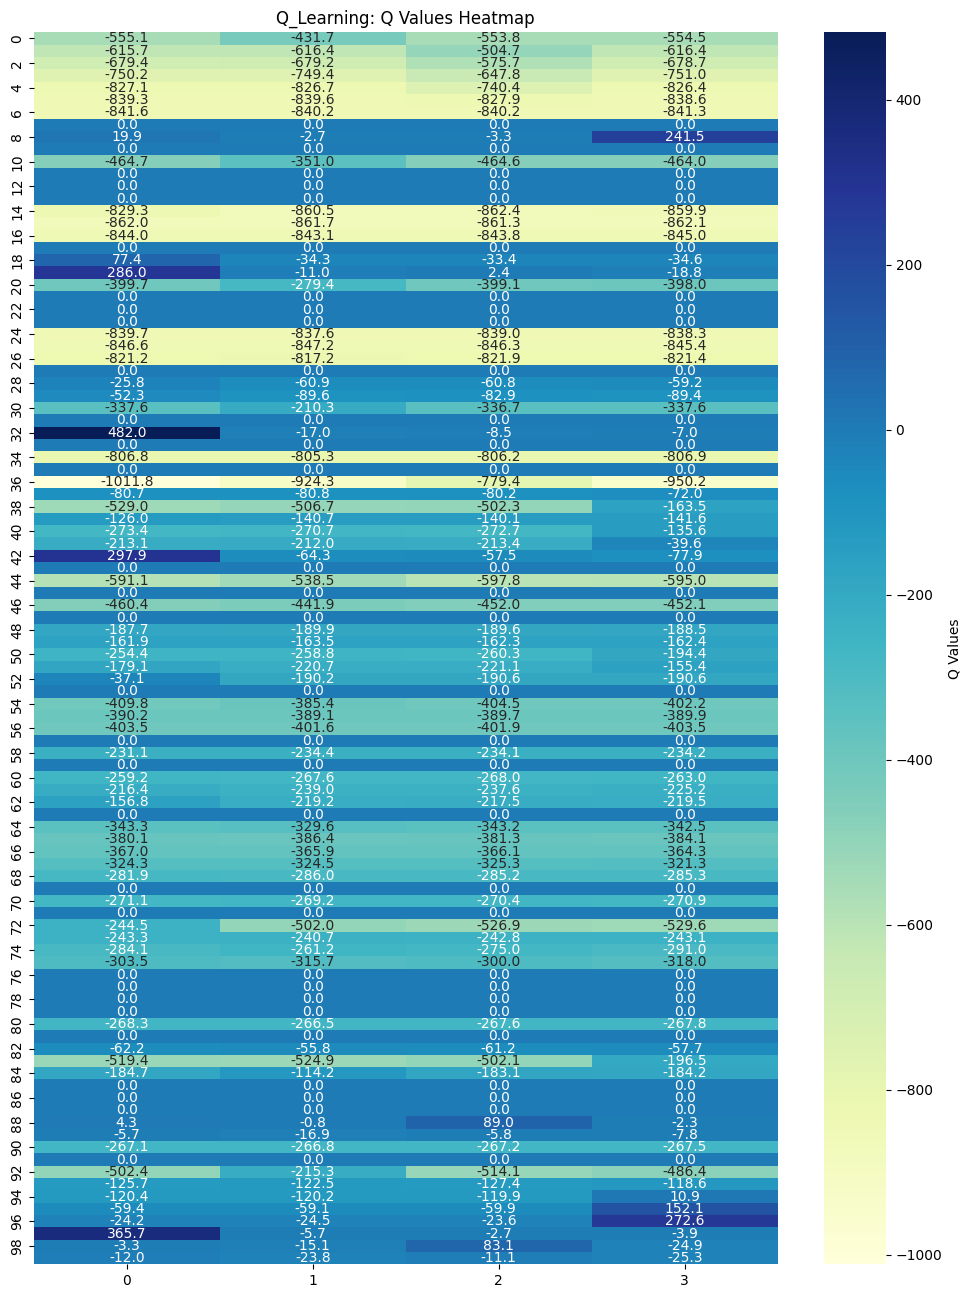

In [ ]:
plt.figure(figsize=(12, 16))
sns.heatmap(q_values, annot=True, fmt=".1f", cmap="YlGnBu", cbar_kws={'label': 'Q Values'})
plt.title('Q_Learning: Q Values Heatmap')
plt.show()

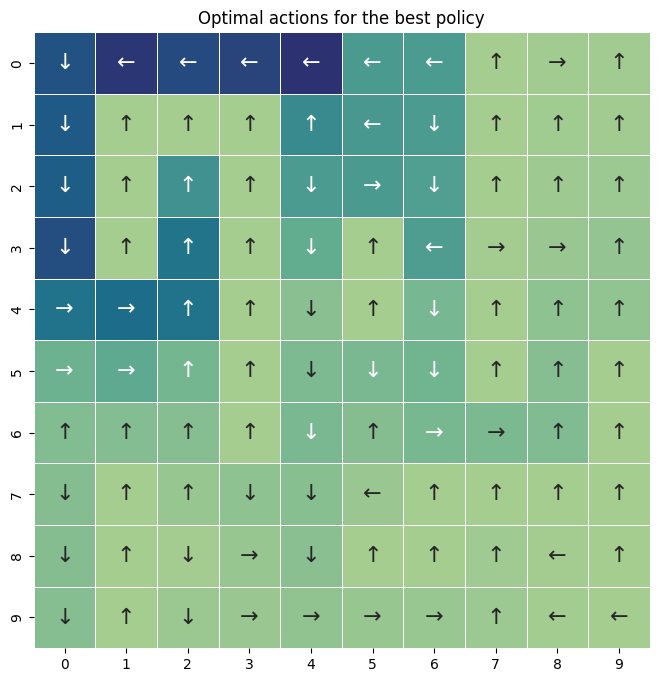

In [ ]:
max_indices = np.argmax(q_values, axis=1)
directions = {0: '↑', 1: '↓', 2: '←', 3: '→'}
direction_labels = np.vectorize(lambda x: directions[x])(max_indices)
direction_grid = direction_labels.reshape((10, 10))

plt.figure(figsize=(10, 8))
sns.heatmap(state_visits_2d, annot=direction_grid, fmt='',cmap="crest",
            cbar=False, linewidths=.5, square=True, annot_kws={'size': 16})
plt.title('Optimal actions for the best policy')
plt.show()

**Analysis 1:**


*   The best choice of hyperparameters for the above config are (alpha=0.1, gamma=1.0, temperature=0.01).
*   The agent  starts with reward close to -160 and converges to -20 after 300 episodes with huge fluctuations

*   Here the agent initally took 100 steps to reach the goal and then converges to 20 steps after 300 episodes with huge fluctuations
---

**Analysis 2:**


*   The agent takes its 1st step left from the start state (0,4) majority of the times

* With epsilon greedy the optimal path is towards the 1st goal state


*   The reason for huge fluctuations in the rewards graph is due to stochasticity=0.7, the agents takes few steps towards the 2nd and 3rd goal by visiting the states in those paths but then moves very rarely towards the 2nd and 3rd goal states and fluctuations in the steps graph are due to the agent hitting the restart states while reaching the 2nd and 3rd goal states



---



### (1) Configuration id << 13 >>

#### Configuration Parameters
Learning algorithm = Q-LEARNING

Wind = False

Start State = (3,6)

Value of $p$ = 1

Exploration strategy = epsilon-greedy

Train the agent

In [ ]:
rewards, steps, state_visits, q_values = q_learning(env_s2_p2, 1.0, 0.7, epsilon=0.05, wind=False)

1. Plot reward curves (during the training phase with the best hyperparameters).

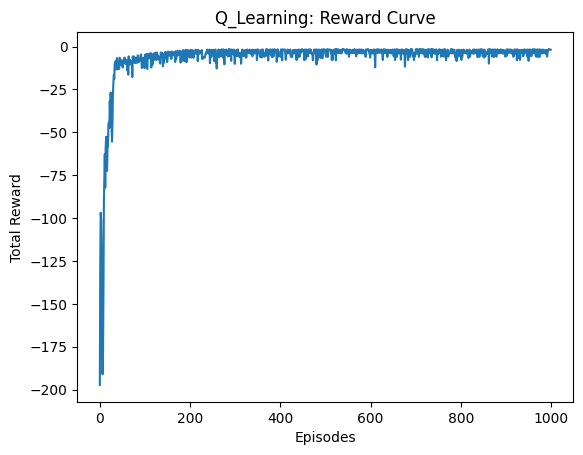

In [ ]:
plt.plot(rewards)
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.title('Q_Learning: Reward Curve')
plt.show()

2. Plot the number of steps to reach the goal in each episode (during the training phase with the best hyperparameters).

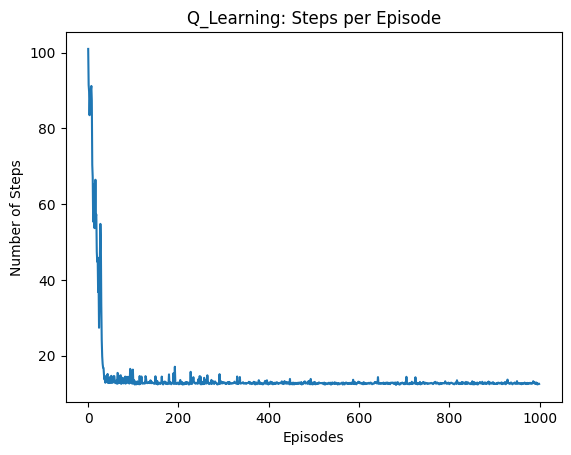

In [ ]:
plt.plot(steps)
plt.xlabel('Episodes')
plt.ylabel('Number of Steps')
plt.title('Q_Learning: Steps per Episode')
plt.show()

3. Heatmap of the grid with state visit counts, i.e., the number of times each state was visited throughout the training phase.

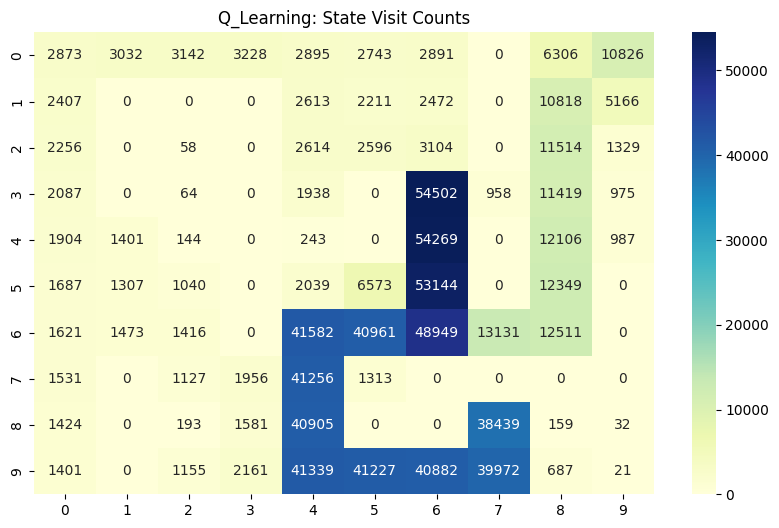

In [ ]:
state_visits_2d = state_visits.reshape((num_rows, num_rows))
plt.figure(figsize=(10, 6))
sns.heatmap(state_visits_2d, annot=True, fmt=".0f",
            cmap="YlGnBu",  cbar=True)
plt.title('Q_Learning: State Visit Counts')
plt.show()

4. Heatmap of the grid with Q values after training is complete, and optimal actions for the best policy.

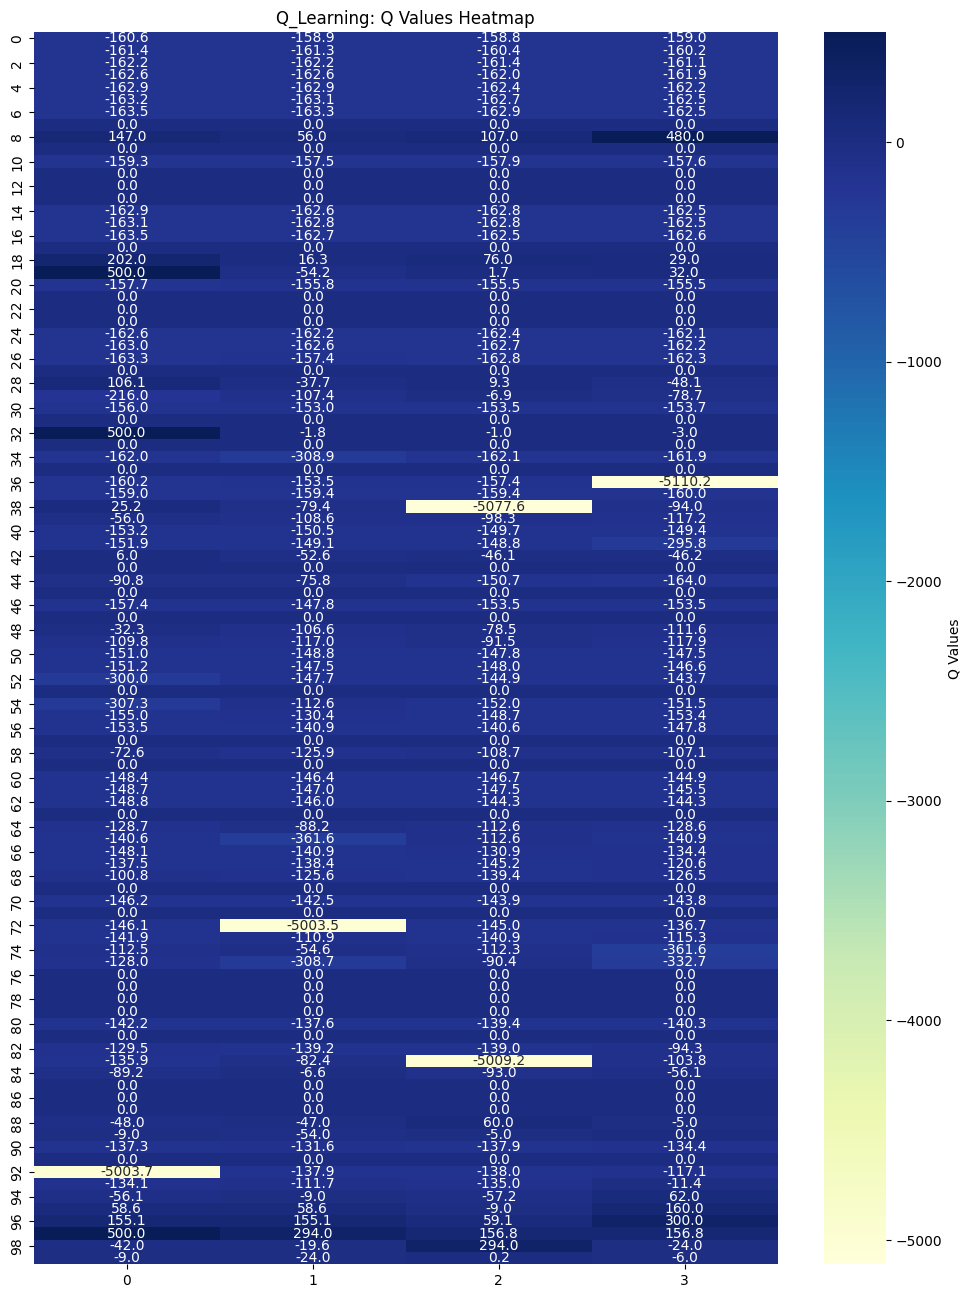

In [ ]:
plt.figure(figsize=(12, 16))
sns.heatmap(q_values, annot=True, fmt=".1f", cmap="YlGnBu", cbar_kws={'label': 'Q Values'})
plt.title('Q_Learning: Q Values Heatmap')
plt.show()

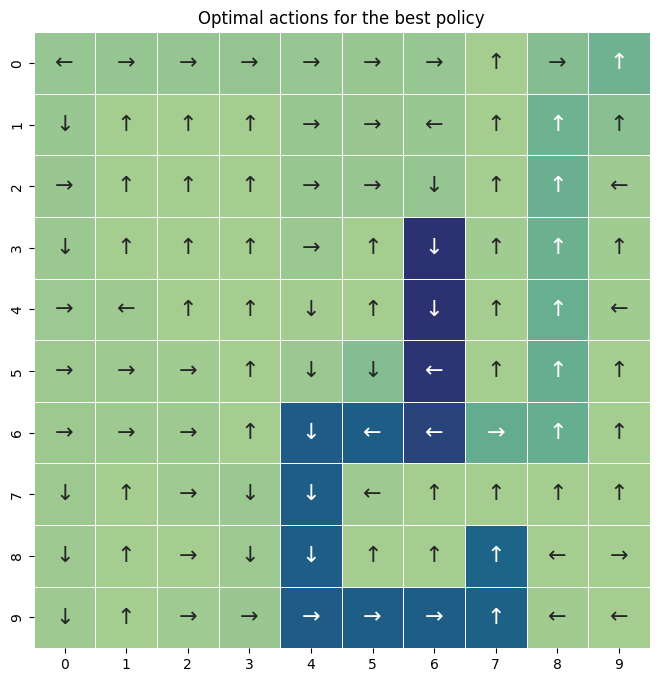

In [ ]:
max_indices = np.argmax(q_values, axis=1)
directions = {0: '↑', 1: '↓', 2: '←', 3: '→'}
direction_labels = np.vectorize(lambda x: directions[x])(max_indices)
direction_grid = direction_labels.reshape((10, 10))

plt.figure(figsize=(10, 8))
sns.heatmap(state_visits_2d, annot=direction_grid, fmt='',cmap="crest",
            cbar=False, linewidths=.5, square=True, annot_kws={'size': 16})
plt.title('Optimal actions for the best policy')
plt.show()

**Analysis 1:**


*   The best choice of hyperparameters for the above config are (alpha=1.0, gamma=0.7, epsilon=0.001).
*   The agent  starts with reward close to -200 and converges to 0 quickly after 50 episodes and then keep fluctuating

*   Here the agent initally took 100 steps to reach the goal and then converges to 20 steps after 50 episodes with minimal fluctuations
---

**Analysis 2:**


*   The agent takes its 1st step down from the start state (3,6) majority of the times

*   But due to a stochasticity of 1, it tends to explore nearby states as well

* With epsilon greedy the optimal path is towards the 3rd goal state (8,7)


*   Since the path to the 3rd goal state (8,7) has no bad states and the restart states are visited very less, there are very few fluctuations in the the reward and steps graph



---



### (1) Configuration id << 14 >>

#### Configuration Parameters
Learning algorithm = Q Learning

Wind = False

Start State = (3,6)

Value of $p$ = 0.7

Exploration strategy = softmax

Train the agent

In [ ]:
rewards, steps, state_visits, q_values = q_learning(env_s2_p2, 1.0, 0.8, temperature=0.1, wind=False)

1. Plot reward curves (during the training phase with the best hyperparameters).

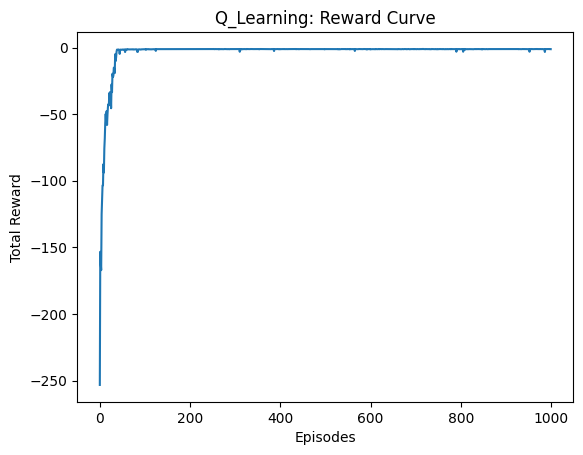

In [ ]:
plt.plot(rewards)
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.title('Q_Learning: Reward Curve')
plt.show()

2. Plot the number of steps to reach the goal in each episode (during the training phase with the best hyperparameters).

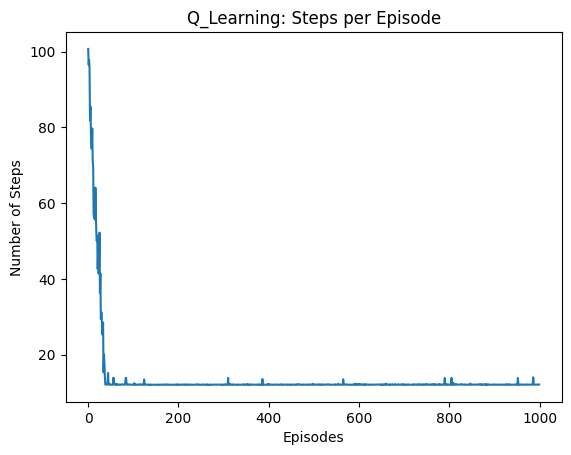

In [ ]:
plt.plot(steps)
plt.xlabel('Episodes')
plt.ylabel('Number of Steps')
plt.title('Q_Learning: Steps per Episode')
plt.show()

3. Heatmap of the grid with state visit counts, i.e., the number of times each state was visited throughout the training phase.

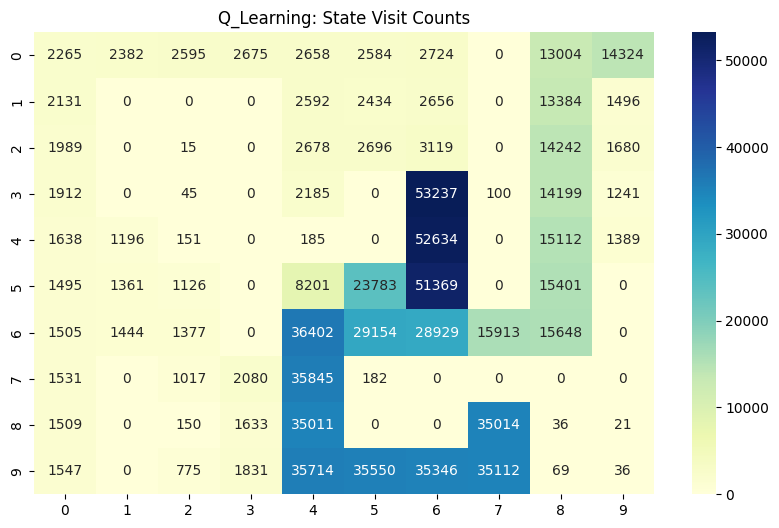

In [ ]:
state_visits_2d = state_visits.reshape((num_rows, num_rows))
plt.figure(figsize=(10, 6))
sns.heatmap(state_visits_2d, annot=True, fmt=".0f",
            cmap="YlGnBu",  cbar=True)
plt.title('Q_Learning: State Visit Counts')
plt.show()

4. Heatmap of the grid with Q values after training is complete, and optimal actions for the best policy.

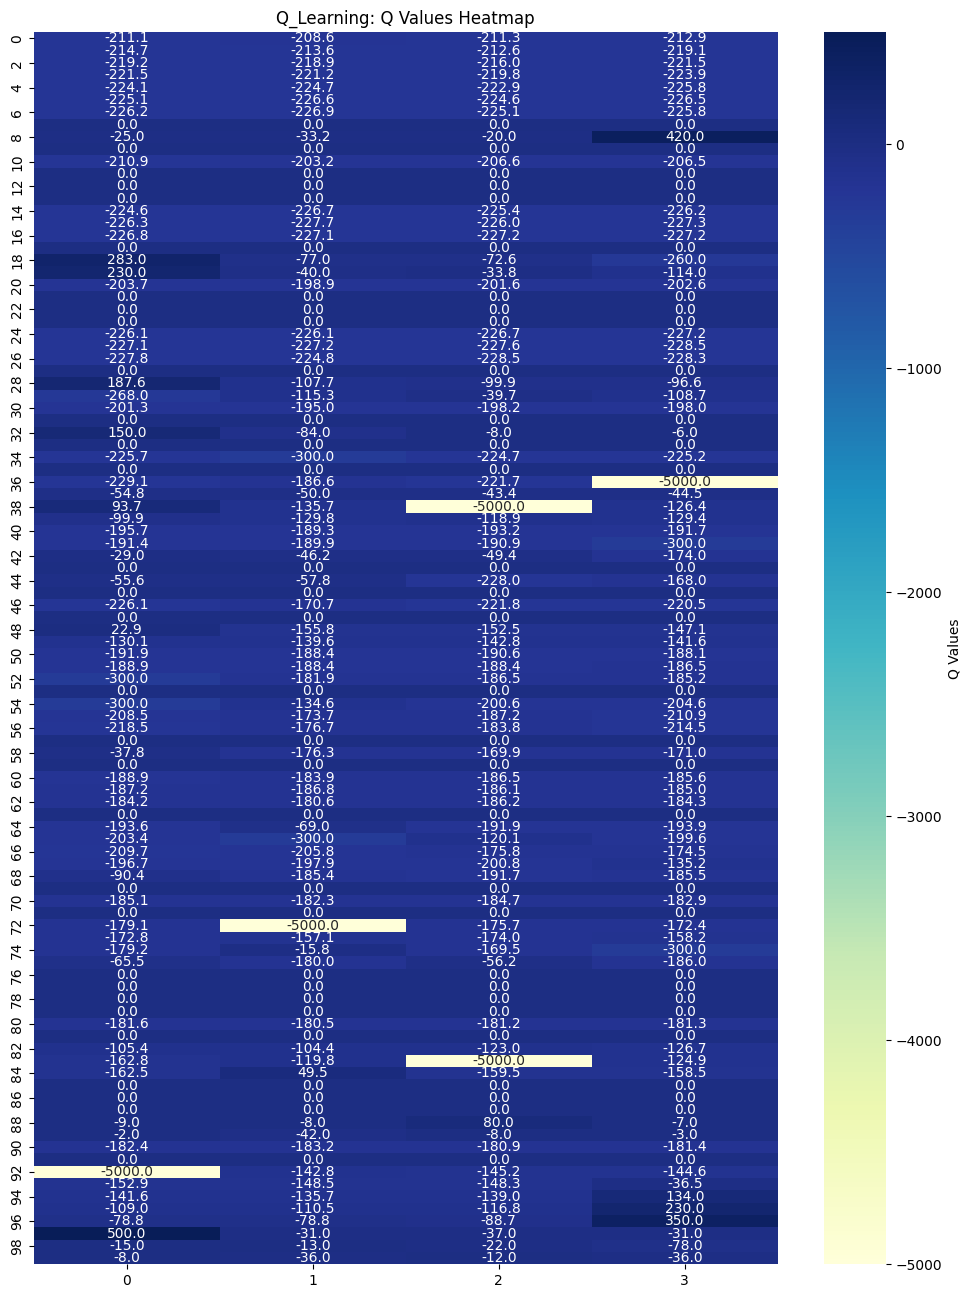

In [ ]:
plt.figure(figsize=(12, 16))
sns.heatmap(q_values, annot=True, fmt=".1f", cmap="YlGnBu", cbar_kws={'label': 'Q Values'})
plt.title('Q_Learning: Q Values Heatmap')
plt.show()

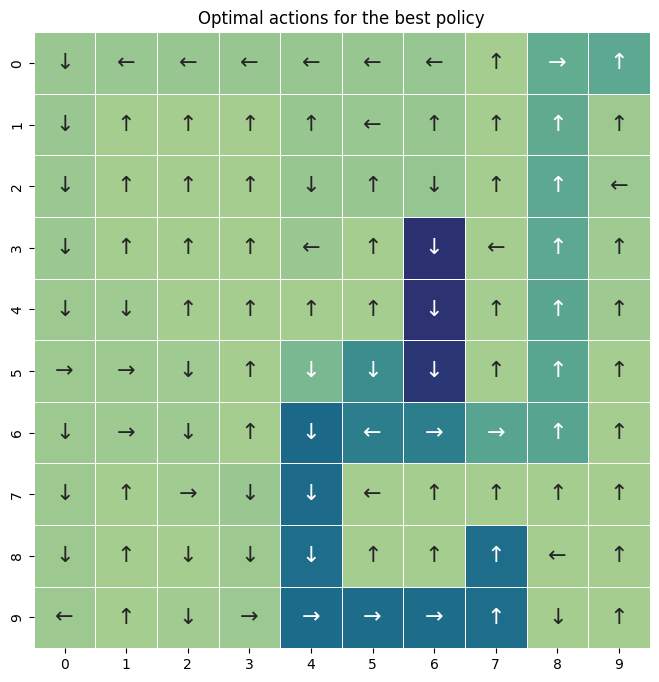

In [ ]:
max_indices = np.argmax(q_values, axis=1)
directions = {0: '↑', 1: '↓', 2: '←', 3: '→'}
direction_labels = np.vectorize(lambda x: directions[x])(max_indices)
direction_grid = direction_labels.reshape((10, 10))

plt.figure(figsize=(10, 8))
sns.heatmap(state_visits_2d, annot=direction_grid, fmt='',cmap="crest",
            cbar=False, linewidths=.5, square=True, annot_kws={'size': 16})
plt.title('Optimal actions for the best policy')
plt.show()

**Analysis 1:**


*   The best choice of hyperparameters for the above config are (alpha=1.0, gamma=0.8, temperature=0.1).
*   The agent  starts with reward close to -250 and converges to 0 quickly after 50 episodes with minimal fluctuations

*   Here the agent initally took 100 steps to reach the goal and then converges to 10 steps after 20 episodes with minimal fluctuations
---

**Analysis 2:**


*   The agent takes its 1st step down from the start state (3,6) majority of the times

*   But due to a stochasticity of 1, it tends to explore nearby states as well

* With softmax the optimal path is towards the 3rd goal state (8,7) which is same path given by epsilon greedy in (config #13)


*   Since the path to the 3rd goal state (8,7) has no bad states and the restart states are visited very less, there are very few fluctuations in the the reward and steps graph



---



### (1) Configuration id << 15 >>

#### Configuration Parameters
Learning algorithm = Q-LEARNING

Wind = False

Start State = (3,6)

Value of $p$ = 0.7

Exploration strategy = epsilon-greedy

Train the agent

In [ ]:
rewards, steps, state_visits, q_values = q_learning(env_s2_p1, 0.1, 1.0, epsilon=0.001, wind=False)

1. Plot reward curves (during the training phase with the best hyperparameters).

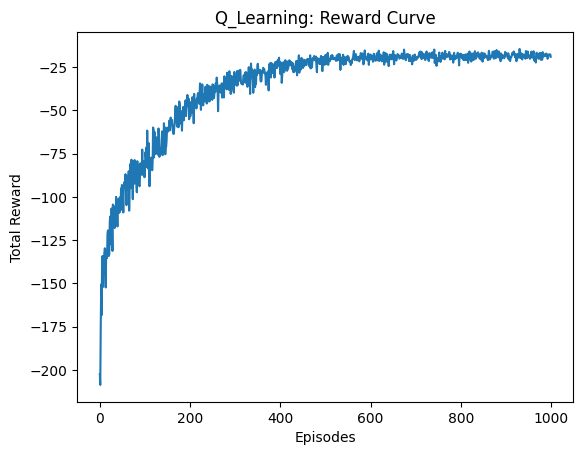

In [ ]:
plt.plot(rewards)
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.title('Q_Learning: Reward Curve')
plt.show()

2. Plot the number of steps to reach the goal in each episode (during the training phase with the best hyperparameters).

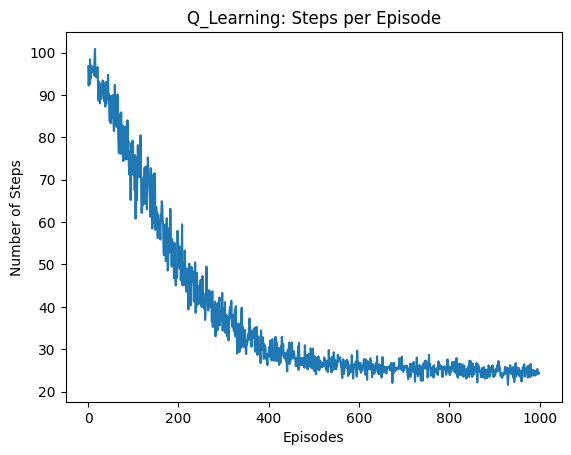

In [ ]:
plt.plot(steps)
plt.xlabel('Episodes')
plt.ylabel('Number of Steps')
plt.title('Q_Learning: Steps per Episode')
plt.show()

3. Heatmap of the grid with state visit counts, i.e., the number of times each state was visited throughout the training phase.

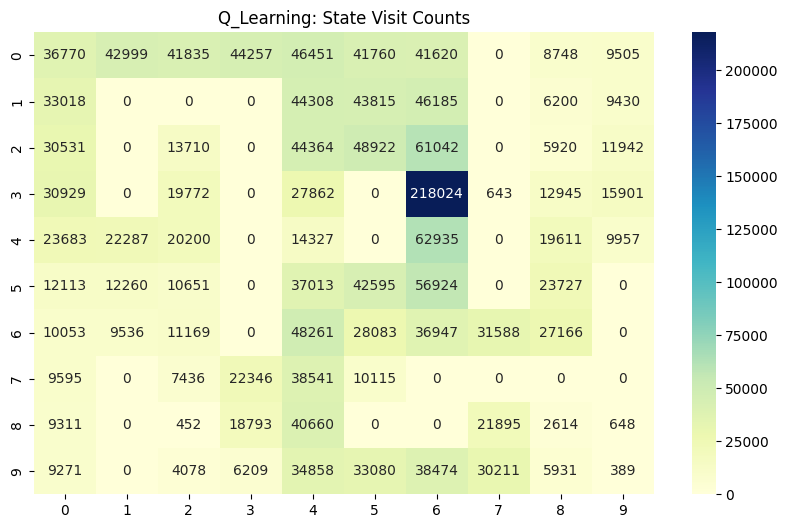

In [ ]:
state_visits_2d = state_visits.reshape((num_rows, num_rows))
plt.figure(figsize=(10, 6))
sns.heatmap(state_visits_2d, annot=True, fmt=".0f",
            cmap="YlGnBu",  cbar=True)
plt.title('Q_Learning: State Visit Counts')
plt.show()

4. Heatmap of the grid with Q values after training is complete, and optimal actions for the best policy.

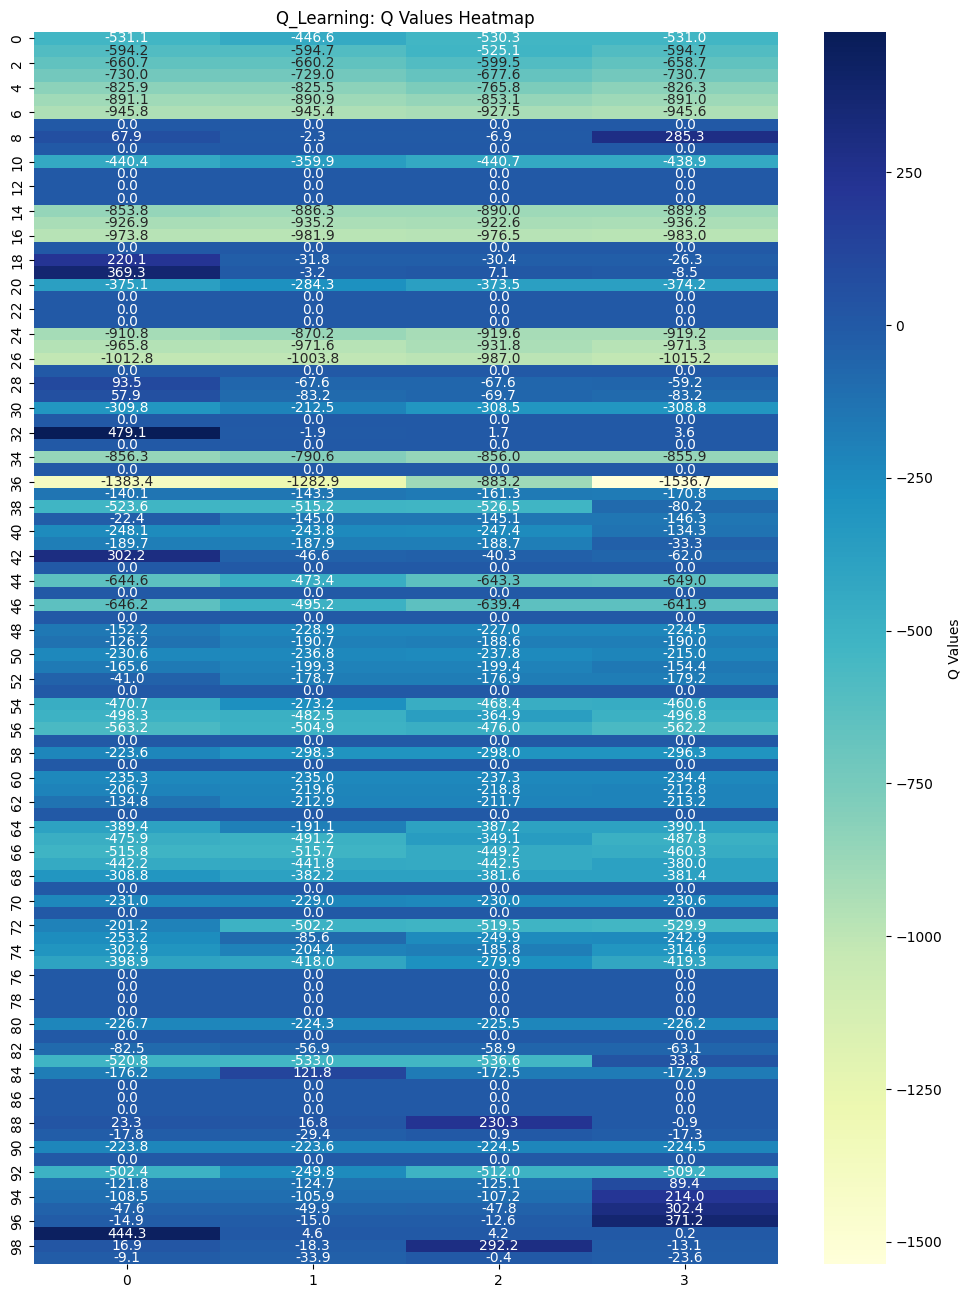

In [ ]:
plt.figure(figsize=(12, 16))
sns.heatmap(q_values, annot=True, fmt=".1f", cmap="YlGnBu", cbar_kws={'label': 'Q Values'})
plt.title('Q_Learning: Q Values Heatmap')
plt.show()

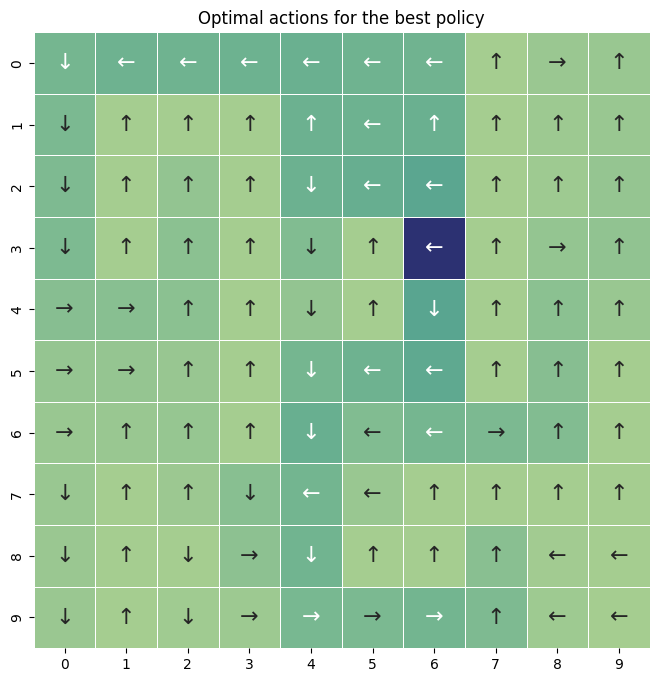

In [ ]:
max_indices = np.argmax(q_values, axis=1)
directions = {0: '↑', 1: '↓', 2: '←', 3: '→'}
direction_labels = np.vectorize(lambda x: directions[x])(max_indices)
direction_grid = direction_labels.reshape((10, 10))

plt.figure(figsize=(10, 8))
sns.heatmap(state_visits_2d, annot=direction_grid, fmt='',cmap="crest",
            cbar=False, linewidths=.5, square=True, annot_kws={'size': 16})
plt.title('Optimal actions for the best policy')
plt.show()

**Analysis 1:**


*   The best choice of hyperparameters for the above config are (alpha=0.1, gamma=1.0, epsilon=0.001).
*   The agent  starts with reward close to -200 and keep fluctuating a lot to converge to -25 after 500 episodes

*   Here the agent initally took 100 steps to reach the goal and keep fluctuating a lot to converge to 20 after 500 episodes
---

**Analysis 2:**


*   The agent takes its 1st step up and down from the start state (3,6) majority of the times

*   But due to a stochasticity of 0.7, it does not explore long enough to get a strong enough path towards its goal state. Here its seen that the Agent is having difficulty in finding a path towards its goal


*   Since the agent tried to reach all the 3 goal states, it runs over all bad and restart states thereby causing huge fluctutations in both reward curve and steps curve


---



### (1) Configuration id << 16 >>

#### Configuration Parameters
Learning algorithm = Q Learning

Wind = False

Start State = (3,6)

Value of $p$ = 0.7

Exploration strategy = softmax

Train the agent

In [ ]:
rewards, steps, state_visits, q_values = q_learning(env_s2_p1, 0.1, 1.0, temperature=0.01, wind=False)

1. Plot reward curves (during the training phase with the best hyperparameters).

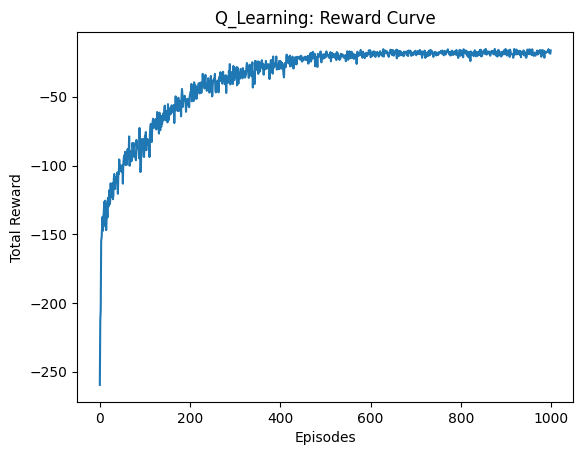

In [ ]:
plt.plot(rewards)
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.title('Q_Learning: Reward Curve')
plt.show()

2. Plot the number of steps to reach the goal in each episode (during the training phase with the best hyperparameters).

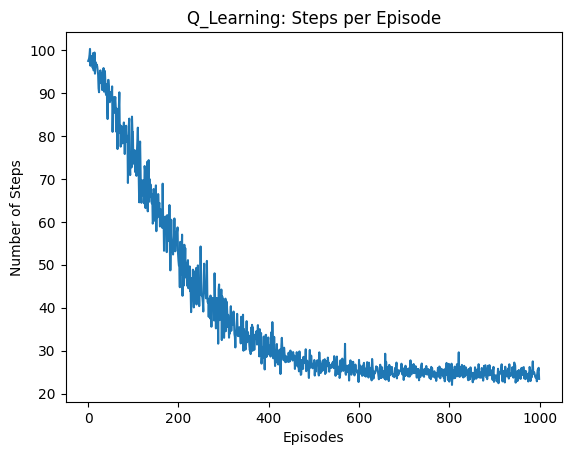

In [ ]:
plt.plot(steps)
plt.xlabel('Episodes')
plt.ylabel('Number of Steps')
plt.title('Q_Learning: Steps per Episode')
plt.show()

3. Heatmap of the grid with state visit counts, i.e., the number of times each state was visited throughout the training phase.

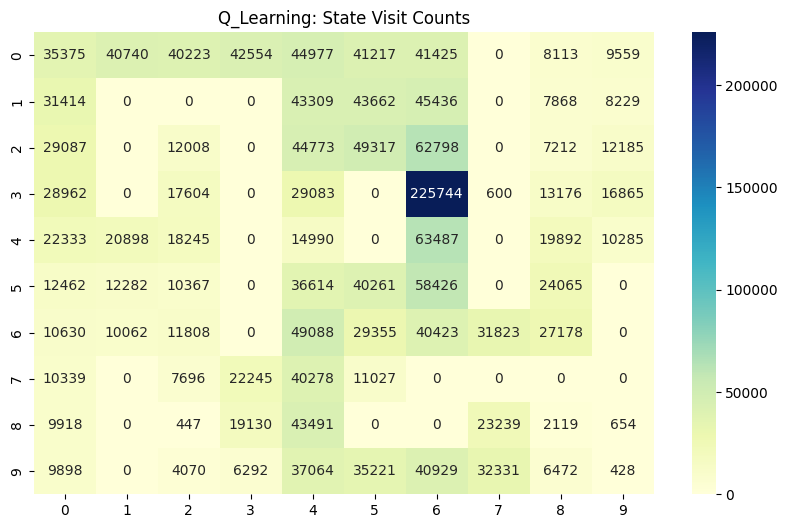

In [ ]:
state_visits_2d = state_visits.reshape((num_rows, num_rows))
plt.figure(figsize=(10, 6))
sns.heatmap(state_visits_2d, annot=True, fmt=".0f",
            cmap="YlGnBu",  cbar=True)
plt.title('Q_Learning: State Visit Counts')
plt.show()

4. Heatmap of the grid with Q values after training is complete, and optimal actions for the best policy.

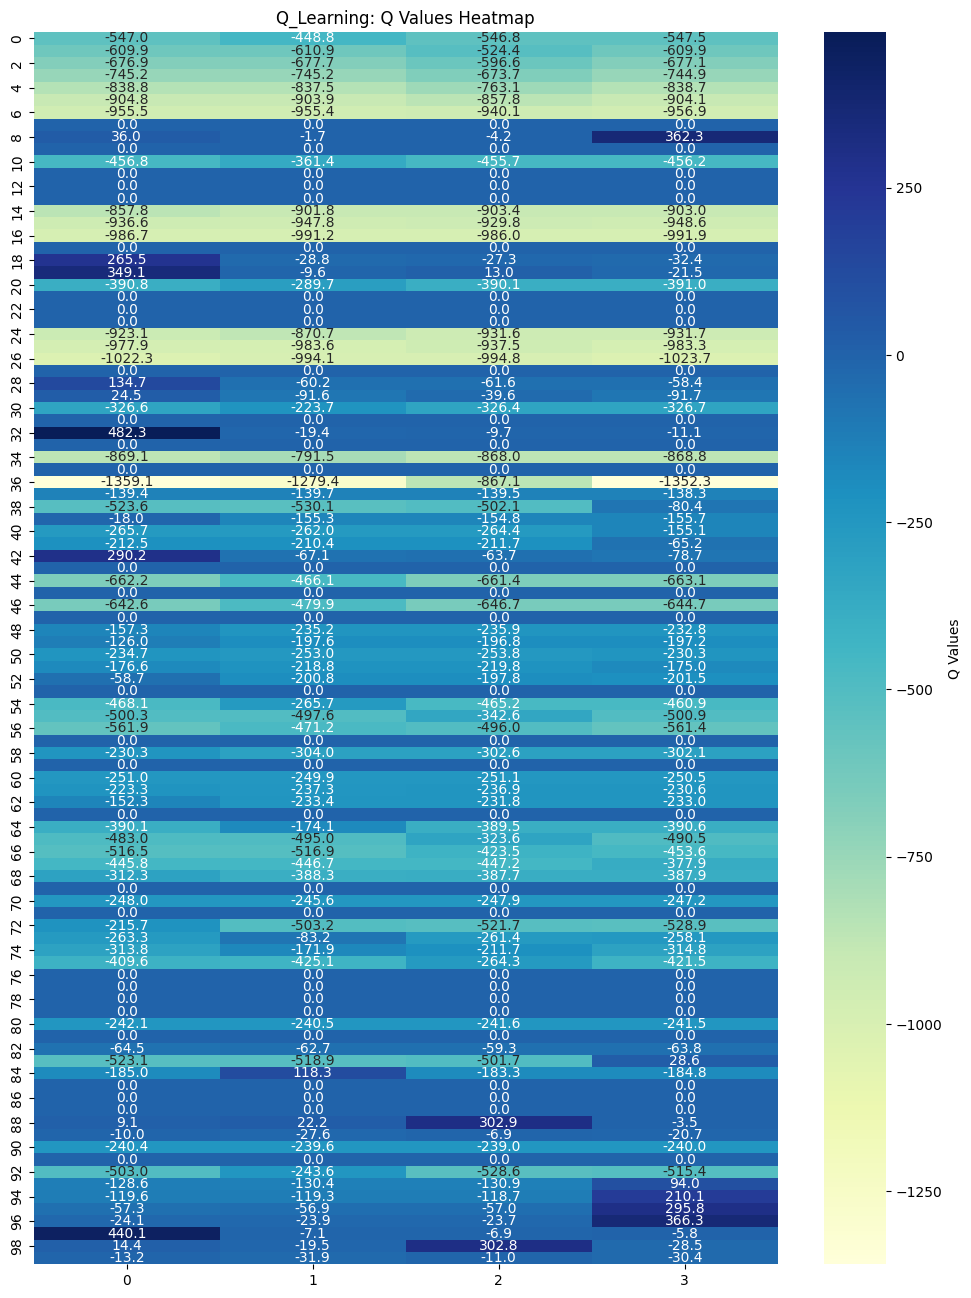

In [ ]:
plt.figure(figsize=(12, 16))
sns.heatmap(q_values, annot=True, fmt=".1f", cmap="YlGnBu", cbar_kws={'label': 'Q Values'})
plt.title('Q_Learning: Q Values Heatmap')
plt.show()

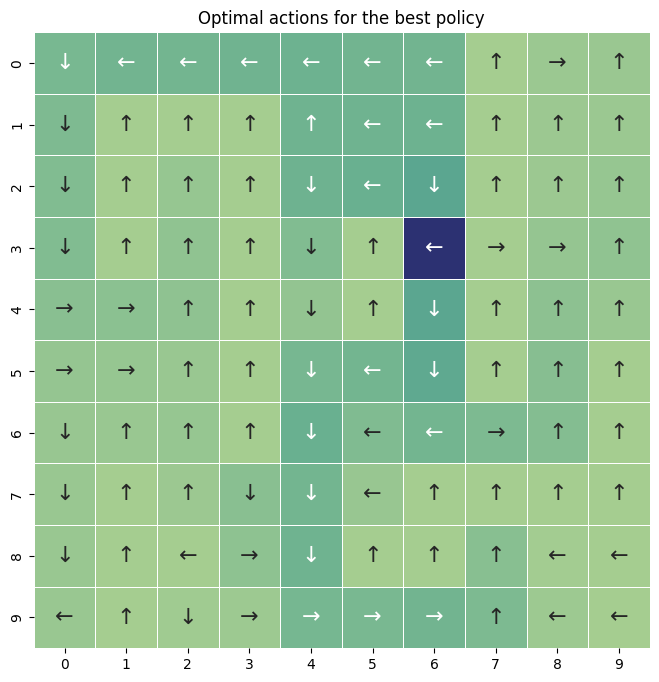

In [ ]:
max_indices = np.argmax(q_values, axis=1)
directions = {0: '↑', 1: '↓', 2: '←', 3: '→'}
direction_labels = np.vectorize(lambda x: directions[x])(max_indices)
direction_grid = direction_labels.reshape((10, 10))

plt.figure(figsize=(10, 8))
sns.heatmap(state_visits_2d, annot=direction_grid, fmt='',cmap="crest",
            cbar=False, linewidths=.5, square=True, annot_kws={'size': 16})
plt.title('Optimal actions for the best policy')
plt.show()

**Analysis 1:**


*   The best choice of hyperparameters for the above config are (alpha=0.1, gamma=1.0, temperature=0.01).
*   The agent  starts with reward close to -250 and keeps fluctuating a lot to converge to -25 after 500 episodes

*   Here the agent initally took 100 steps to reach the goal and keeps fluctuating a lot to converge to 20 after 500 episodes
---

**Analysis 2:**


*   The agent takes its 1st step up and down from the start state (3,6) majority of the times

*   But due to a stochasticity of 0.7, it does not explore long enough to get a strong enough path towards its goal state. Here its seen that the Agent is having difficulty in finding a path towards its goal


*   Since the agent tried to reach all the 3 goal states, it runs over all bad and restart states thereby causing huge fluctutations in both reward curve and steps curve


---

## Final Analysis

*   The optimal path which contains path towards the 3rd Goal State (8,7) results in the least amount of fluctuations in both reward and steps curve
*   Wind causes the agent to shift its path towards the states in the right if there are no obstructed states
*   Stochasticity = 0.7 results in the Agent exploiting too soon and not finding a strong enough path towards the goal state